# 🎯 XGBoost Model Training Pipeline
## State Business Risk Scoring Platform - Layer 1: ML Predictions

---

### 📋 Notebook Overview

This notebook trains **two production-ready XGBoost models** for predicting small business financial risk:

| Model | Target | Type | Purpose |
|-------|--------|------|--------|
| **Classifier** | `default_flag` | Binary (0/1) | Will this business default in 12 months? |
| **Regressor** | `risk_score` | Continuous (0-100) | What is the severity of risk? |

### 🔢 Dataset Summary
- **15,000 businesses** from Louisiana parishes
- **43 input features** (financial, operational, credit, IGS benchmarks)
- **2 target variables** (risk_score, default_flag)

---

## 📦 1. Environment Setup & Imports

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
#                           IMPORTS & CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Sklearn - preprocessing & model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    # Classification metrics
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    # Regression metrics
    mean_absolute_error, mean_squared_error, r2_score
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# Model persistence
import pickle
import joblib
from datetime import datetime
import os

# ═══════════════════════════════════════════════════════════════════════════════
#                           PLOTTING CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Custom color palette for risk visualization
RISK_COLORS = {
    'low': '#2ECC71',      # Green
    'medium': '#F39C12',   # Orange  
    'high': '#E74C3C',     # Red
    'primary': '#3498DB',  # Blue
    'secondary': '#9B59B6' # Purple
}

# Gradient colormap for risk scores
risk_cmap = LinearSegmentedColormap.from_list(
    'risk', ['#2ECC71', '#F39C12', '#E74C3C'], N=100
)

# Figure defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Libraries imported successfully!")
print(f"📅 Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 XGBoost version: {xgb.__version__}")

✅ Libraries imported successfully!
📅 Training started: 2025-12-01 23:28:43
🔧 XGBoost version: 3.1.2


## 📁 2. Load Dataset

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
#                              LOAD DATASET
# ═══════════════════════════════════════════════════════════════════════════════

# Use relative path from the notebooks folder
DATA_PATH = '../datasets/synthetic_xgboost_training_data.csv'

# Load data
df = pd.read_csv(DATA_PATH)

print("═" * 70)
print("                    📁 DATASET LOADED SUCCESSFULLY")
print("═" * 70)
print(f"\n📏 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"📂 Loaded from: {DATA_PATH}")
print("\n" + "─" * 70)
print("📋 Column Overview:")
print("─" * 70)

# Categorize columns
print(f"\n   🆔 ID Column: business_id")
print(f"   🎯 Target Variables: risk_score, default_flag")
print(f"   📊 Feature Columns: {df.shape[1] - 3} features")

══════════════════════════════════════════════════════════════════════
                    📁 DATASET LOADED SUCCESSFULLY
══════════════════════════════════════════════════════════════════════

📏 Shape: 15,000 rows × 43 columns
💾 Memory usage: 6.62 MB
📂 Loaded from: ../datasets/synthetic_xgboost_training_data.csv

──────────────────────────────────────────────────────────────────────
📋 Column Overview:
──────────────────────────────────────────────────────────────────────

   🆔 ID Column: business_id
   🎯 Target Variables: risk_score, default_flag
   📊 Feature Columns: 40 features


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
#                           DATA STRUCTURE OVERVIEW
# ═══════════════════════════════════════════════════════════════════════════════

# Display first few rows
print("\n📋 First 5 Rows:")
print("─" * 70)
df.head()


📋 First 5 Rows:
──────────────────────────────────────────────────────────────────────


,business_id,industry_sector,business_age_years,region_parish,annual_revenue,revenue_growth_yoy,profit_margin,avg_bank_balance,cash_to_monthly_expense_ratio,overdraft_days_last_12m,...,igs_labor_market_engagement_index,igs_minority_women_owned_pct,igs_commercial_diversity_pct,igs_tract_population,igs_median_income_tract,revenue_growth_vs_tract_benchmark,spending_growth_vs_tract_benchmark,labor_market_health_score,risk_score,default_flag
0,100001,Construction,5.3,Ouachita,1453911,-0.1596,0.2852,158889.65,1.83,0,...,47.3,0.2004,0.0097,3784,49817,-0.0021,-0.2640,27.66,56,0
1,100002,Agriculture,3.6,Caddo,2269670,0.4690,0.1937,222528.91,1.46,0,...,46.3,0.5512,0.0149,8012,53375,0.6209,0.4612,27.08,17,0
2,100003,Manufacturing,2.2,Caddo,918253,0.3753,0.1853,34326.77,0.55,0,...,63.2,0.1595,0.0075,8825,51175,0.4577,-0.3192,55.28,73,0
3,100004,Professional Services,0.5,Calcasieu,249438,0.0221,0.0547,8306.66,0.42,0,...,49.8,0.6888,0.0207,8085,42970,-0.0036,-0.1477,35.76,100,1
4,100005,Retail,2.7,East Baton Rouge,63483,-0.0362,0.1010,2322.34,0.49,0,...,61.6,0.3250,0.0115,2289,37699,-0.0506,-0.1127,24.55,68,0


In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
#                              DATA TYPES & INFO
# ═══════════════════════════════════════════════════════════════════════════════

print("\n📊 Data Types Summary:")
print("─" * 70)

dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count} columns")
r
print("\n📋 Column Details:")
print("─" * 70)
df.info()


📊 Data Types Summary:
──────────────────────────────────────────────────────────────────────
   float64: 25 columns
   int64: 16 columns
   object: 2 columns


NameError: name 'r' is not defined


🔍 Missing Values Analysis:
══════════════════════════════════════════════════════════════════════

⚠️  7 columns have missing values:

                               Missing Count  Missing %
utilization_rate_card                   6076      40.51
card_spend_growth_yoy                   6076      40.51
credit_score_business                   1800      12.00
total_payroll_last_12m                  1200       8.00
missed_payroll_count_last_12m           1200       8.00
avg_bank_balance                         750       5.00
cash_to_monthly_expense_ratio            750       5.00


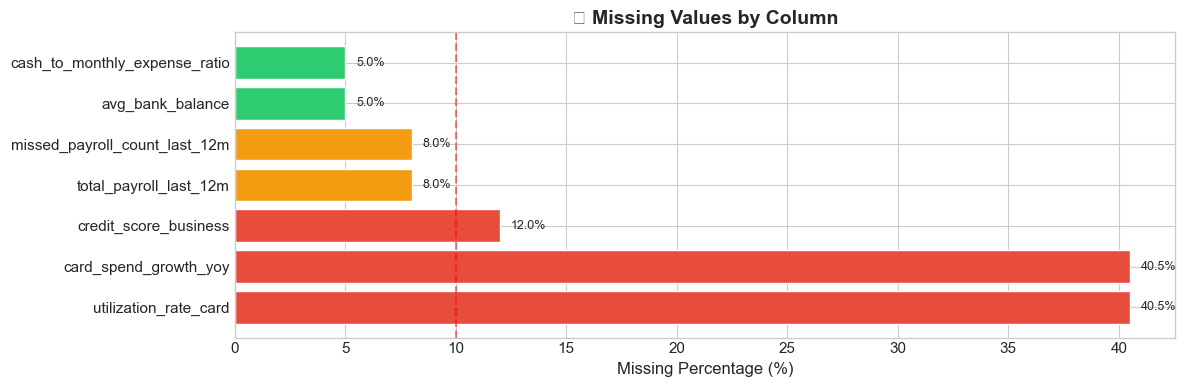

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
#                           MISSING VALUES ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

# Filter to show only columns with missing values
missing_cols = missing_df[missing_df['Missing Count'] > 0]

print("\n🔍 Missing Values Analysis:")
print("═" * 70)

if len(missing_cols) > 0:
    print(f"\n⚠️  {len(missing_cols)} columns have missing values:\n")
    print(missing_cols.to_string())
else:
    print("\n✅ No missing values found in the dataset!")

# Visualize missing values if any
if len(missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, max(4, len(missing_cols) * 0.4)))
    colors = [RISK_COLORS['high'] if pct > 10 else RISK_COLORS['medium'] if pct > 5 else RISK_COLORS['low'] 
              for pct in missing_cols['Missing %']]
    bars = ax.barh(missing_cols.index, missing_cols['Missing %'], color=colors, edgecolor='white')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('📊 Missing Values by Column', fontsize=14, fontweight='bold')
    ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
    
    # Add value labels
    for bar, pct in zip(bars, missing_cols['Missing %']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
#                         STATISTICAL SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

print("\n📈 Statistical Summary (Numerical Features):")
print("═" * 70)
df.describe().T.round(2)


📈 Statistical Summary (Numerical Features):
══════════════════════════════════════════════════════════════════════


,count,mean,std,min,25%,50%,75%,max
business_id,15000.0,107500.50,4330.27,100001.00,103750.75,107500.50,111250.25,115000.00
business_age_years,15000.0,6.95,4.93,0.50,3.30,5.80,9.40,35.00
annual_revenue,15000.0,837907.31,1032411.37,9339.00,271930.00,522454.50,997674.00,19208795.00
revenue_growth_yoy,15000.0,0.03,0.22,-0.85,-0.12,0.03,0.18,0.86
profit_margin,15000.0,0.16,0.10,-0.20,0.09,0.16,0.23,0.45
avg_bank_balance,14250.0,40322.66,60532.17,235.26,9882.08,21902.58,46413.39,1181586.91
cash_to_monthly_expense_ratio,14250.0,0.70,0.40,0.00,0.39,0.63,0.92,2.87
overdraft_days_last_12m,15000.0,1.50,3.55,0.00,0.00,0.00,0.00,23.00
loan_amount_outstanding,15000.0,609951.82,1084011.09,0.00,0.00,272699.00,735229.50,27134642.00
debt_to_revenue,15000.0,0.73,0.59,0.00,0.00,0.70,1.24,1.80


## 🎯 3. Target Variable Analysis

In [44]:
# ═══════════════════════════════════════════════════════════════════════════════
#                        TARGET VARIABLES OVERVIEW
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🎯 TARGET VARIABLES ANALYSIS")
print("═" * 70)

# Default Flag Distribution
default_counts = df['default_flag'].value_counts()
default_pct = df['default_flag'].value_counts(normalize=True) * 100

print("\n📊 default_flag (Binary Classification Target):")
print("─" * 50)
print(f"   Class 0 (No Default): {default_counts[0]:,} ({default_pct[0]:.1f}%)")
print(f"   Class 1 (Default):    {default_counts[1]:,} ({default_pct[1]:.1f}%)")
print(f"   Imbalance Ratio:      {default_counts[0]/default_counts[1]:.2f}:1")

# Risk Score Distribution
print("\n📊 risk_score (Regression Target):")
print("─" * 50)
print(f"   Min:    {df['risk_score'].min()}")
print(f"   Max:    {df['risk_score'].max()}")
print(f"   Mean:   {df['risk_score'].mean():.2f}")
print(f"   Median: {df['risk_score'].median()}")
print(f"   Std:    {df['risk_score'].std():.2f}")


🎯 TARGET VARIABLES ANALYSIS
══════════════════════════════════════════════════════════════════════

📊 default_flag (Binary Classification Target):
──────────────────────────────────────────────────
   Class 0 (No Default): 11,858 (79.1%)
   Class 1 (Default):    3,142 (20.9%)
   Imbalance Ratio:      3.77:1

📊 risk_score (Regression Target):
──────────────────────────────────────────────────
   Min:    0
   Max:    100
   Mean:   46.64
   Median: 43.0
   Std:    31.74


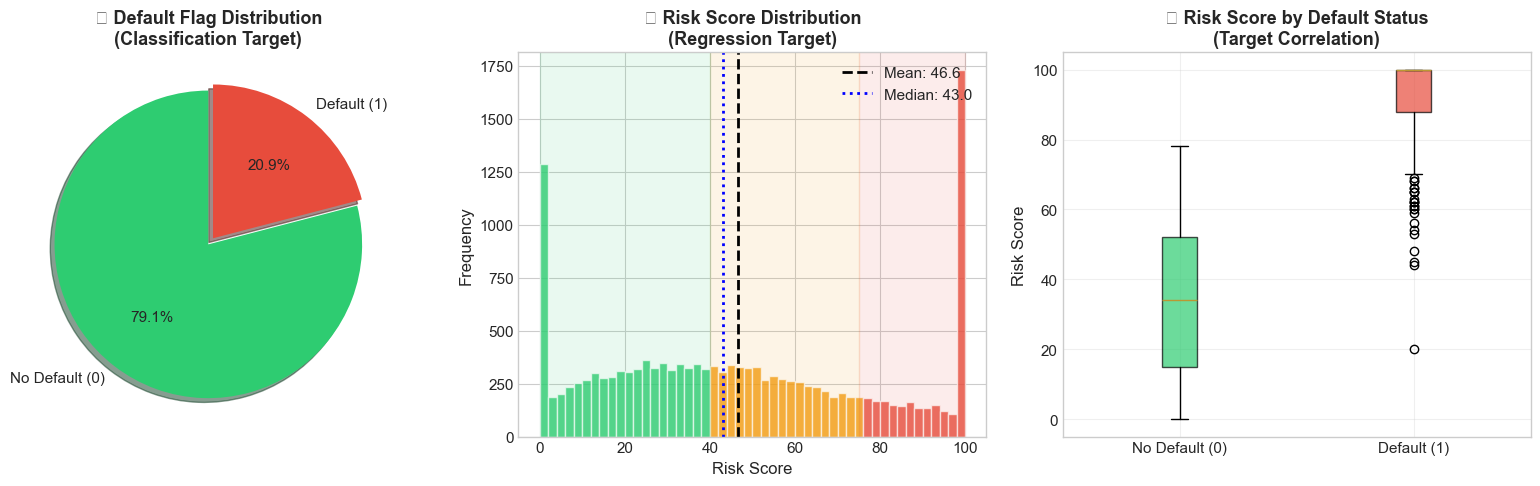


📈 Correlation between risk_score and default_flag: 0.7669


In [45]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    TARGET VARIABLES VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Default Flag Distribution (Pie Chart)
# ─────────────────────────────────────────────────────────────────────────────
colors_pie = [RISK_COLORS['low'], RISK_COLORS['high']]
explode = (0, 0.05)
axes[0].pie(default_counts.values, labels=['No Default (0)', 'Default (1)'], 
            autopct='%1.1f%%', colors=colors_pie, explode=explode,
            shadow=True, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('🎯 Default Flag Distribution\n(Classification Target)', 
                   fontsize=13, fontweight='bold')

# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Risk Score Distribution (Histogram)
# ─────────────────────────────────────────────────────────────────────────────
n, bins, patches = axes[1].hist(df['risk_score'], bins=50, edgecolor='white', alpha=0.8)

# Color bars by risk level
for i, (patch, left_edge) in enumerate(zip(patches, bins[:-1])):
    if left_edge < 40:
        patch.set_facecolor(RISK_COLORS['low'])
    elif left_edge < 75:
        patch.set_facecolor(RISK_COLORS['medium'])
    else:
        patch.set_facecolor(RISK_COLORS['high'])

axes[1].axvline(df['risk_score'].mean(), color='black', linestyle='--', 
                linewidth=2, label=f"Mean: {df['risk_score'].mean():.1f}")
axes[1].axvline(df['risk_score'].median(), color='blue', linestyle=':', 
                linewidth=2, label=f"Median: {df['risk_score'].median()}")
axes[1].set_xlabel('Risk Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('📊 Risk Score Distribution\n(Regression Target)', 
                   fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right')

# Add risk band annotations
axes[1].axvspan(0, 40, alpha=0.1, color=RISK_COLORS['low'], label='Low Risk')
axes[1].axvspan(40, 75, alpha=0.1, color=RISK_COLORS['medium'], label='Medium Risk')
axes[1].axvspan(75, 100, alpha=0.1, color=RISK_COLORS['high'], label='High Risk')

# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: Risk Score by Default Flag (Box Plot)
# ─────────────────────────────────────────────────────────────────────────────
bp = axes[2].boxplot([df[df['default_flag']==0]['risk_score'], 
                      df[df['default_flag']==1]['risk_score']],
                     labels=['No Default (0)', 'Default (1)'],
                     patch_artist=True)

bp['boxes'][0].set_facecolor(RISK_COLORS['low'])
bp['boxes'][1].set_facecolor(RISK_COLORS['high'])
for box in bp['boxes']:
    box.set_alpha(0.7)

axes[2].set_ylabel('Risk Score')
axes[2].set_title('🔗 Risk Score by Default Status\n(Target Correlation)', 
                   fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between targets
corr = df['risk_score'].corr(df['default_flag'])
print(f"\n📈 Correlation between risk_score and default_flag: {corr:.4f}")


📊 Risk Band Distribution:
══════════════════════════════════════════════════════════════════════
                Count  Avg Risk Score  Std Dev  Default Rate  Percentage
risk_band                                                               
Low (0-40)       7042          18.404   13.038         0.000        46.9
Medium (41-75)   4603          56.040    9.870         0.009        30.7
High (76-100)    3355          93.013    8.343         0.924        22.4


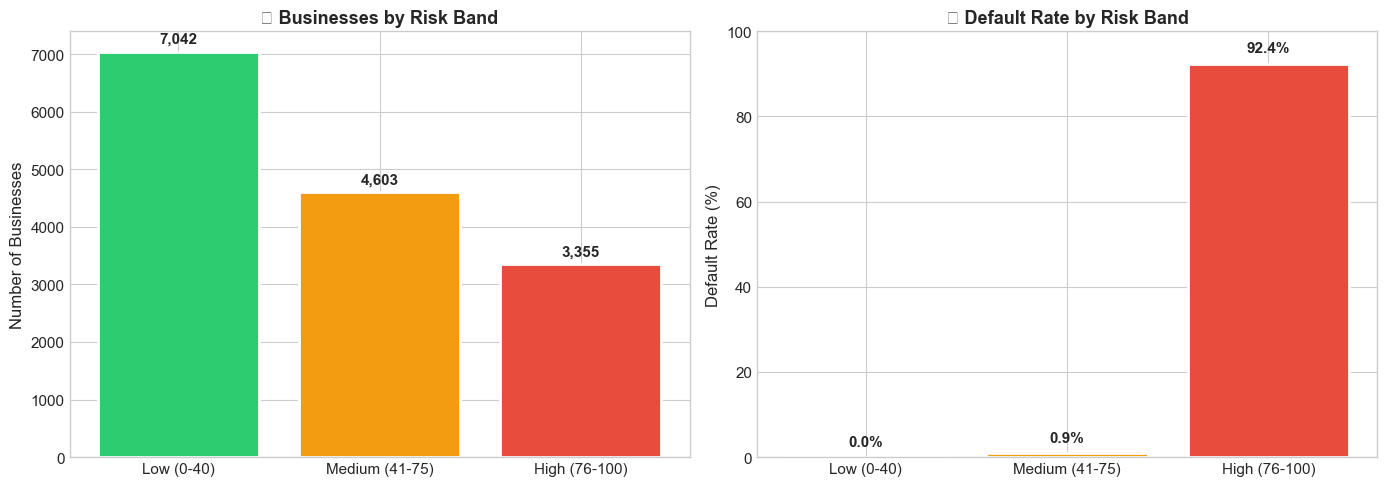

In [46]:
# ═══════════════════════════════════════════════════════════════════════════════
#                         RISK BANDS ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

# Create risk bands
df['risk_band'] = pd.cut(df['risk_score'], 
                          bins=[-1, 40, 75, 100], 
                          labels=['Low (0-40)', 'Medium (41-75)', 'High (76-100)'])

risk_band_stats = df.groupby('risk_band').agg({
    'risk_score': ['count', 'mean', 'std'],
    'default_flag': 'mean'
}).round(3)

risk_band_stats.columns = ['Count', 'Avg Risk Score', 'Std Dev', 'Default Rate']
risk_band_stats['Percentage'] = (risk_band_stats['Count'] / len(df) * 100).round(1)

print("\n📊 Risk Band Distribution:")
print("═" * 70)
print(risk_band_stats.to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk band counts
colors = [RISK_COLORS['low'], RISK_COLORS['medium'], RISK_COLORS['high']]
bars = axes[0].bar(risk_band_stats.index, risk_band_stats['Count'], 
                   color=colors, edgecolor='white', linewidth=2)
axes[0].set_ylabel('Number of Businesses')
axes[0].set_title('📊 Businesses by Risk Band', fontsize=13, fontweight='bold')

# Add count labels
for bar, count in zip(bars, risk_band_stats['Count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Default rate by risk band
bars2 = axes[1].bar(risk_band_stats.index, risk_band_stats['Default Rate'] * 100, 
                    color=colors, edgecolor='white', linewidth=2)
axes[1].set_ylabel('Default Rate (%)')
axes[1].set_title('📈 Default Rate by Risk Band', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 100)

# Add percentage labels
for bar, rate in zip(bars2, risk_band_stats['Default Rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{rate*100:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop('risk_band', axis=1, inplace=True)

## 🔍 4. Exploratory Data Analysis (EDA)

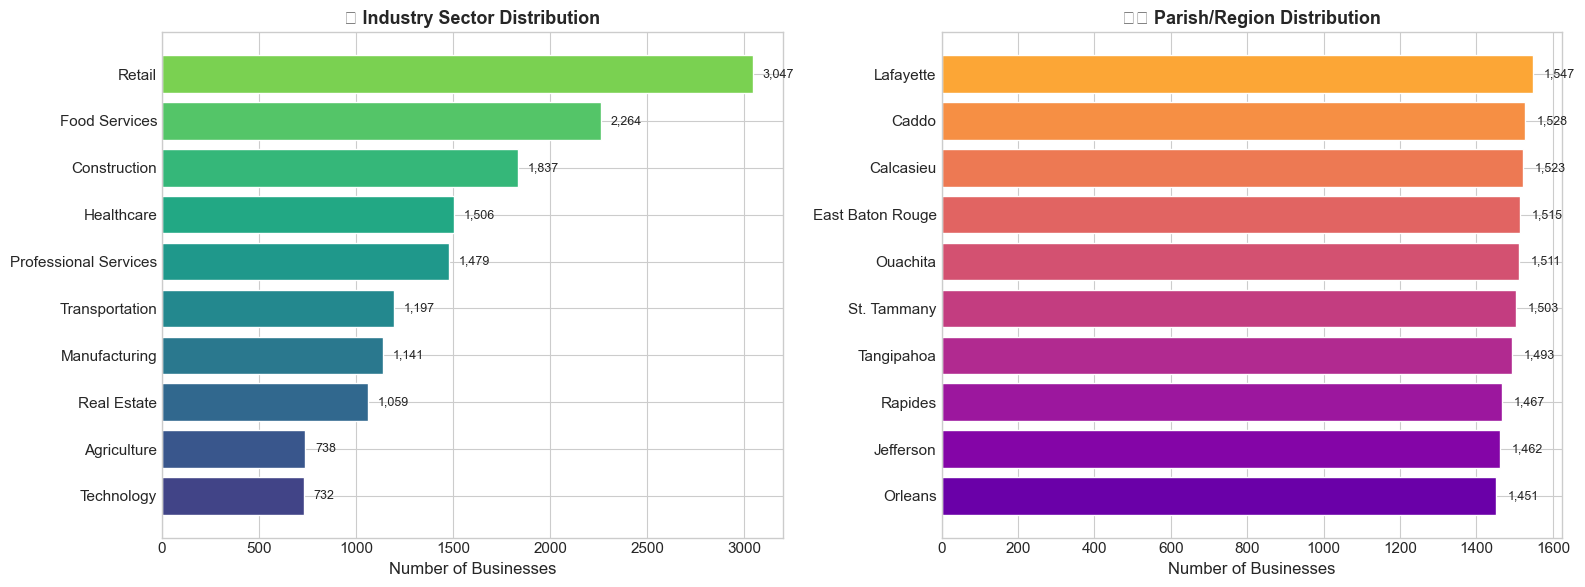

In [64]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    INDUSTRY & GEOGRAPHIC DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ─────────────────────────────────────────────────────────────────────────────
# Industry Sector Distribution with Default Rate
# ─────────────────────────────────────────────────────────────────────────────
industry_stats = df.groupby('industry_sector').agg({
    'business_id': 'count',
    'default_flag': 'mean',
    'risk_score': 'mean'
}).rename(columns={'business_id': 'count', 'default_flag': 'default_rate', 'risk_score': 'avg_risk'})
industry_stats = industry_stats.sort_values('count', ascending=True)

colors_ind = plt.cm.viridis(np.linspace(0.2, 0.8, len(industry_stats)))
bars = axes[0].barh(industry_stats.index, industry_stats['count'], color=colors_ind, edgecolor='white')
axes[0].set_xlabel('Number of Businesses')
axes[0].set_title('🏭 Industry Sector Distribution', fontsize=13, fontweight='bold')

# Add count labels
for bar, count in zip(bars, industry_stats['count']):
    axes[0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                 f'{count:,}', va='center', fontsize=9)

# ─────────────────────────────────────────────────────────────────────────────
# Parish/Region Distribution with Default Rate
# ─────────────────────────────────────────────────────────────────────────────
parish_stats = df.groupby('region_parish').agg({
    'business_id': 'count',
    'default_flag': 'mean',
    'risk_score': 'mean'
}).rename(columns={'business_id': 'count', 'default_flag': 'default_rate', 'risk_score': 'avg_risk'})
parish_stats = parish_stats.sort_values('count', ascending=True)

colors_par = plt.cm.plasma(np.linspace(0.2, 0.8, len(parish_stats)))
bars2 = axes[1].barh(parish_stats.index, parish_stats['count'], color=colors_par, edgecolor='white')
axes[1].set_xlabel('Number of Businesses')
axes[1].set_title('🗺️ Parish/Region Distribution', fontsize=13, fontweight='bold')

# Add count labels
for bar, count in zip(bars2, parish_stats['count']):
    axes[1].text(bar.get_width() + 30, bar.get_y() + bar.get_height()/2, 
                 f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

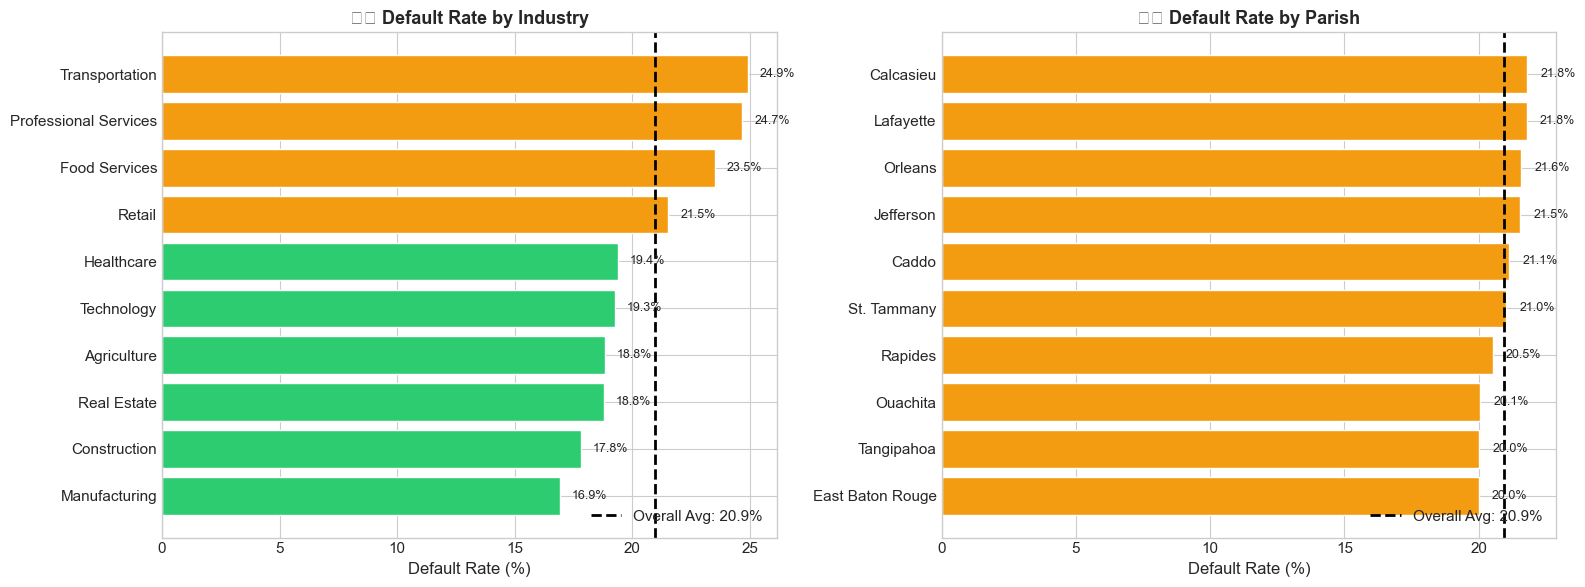

In [65]:
# ═══════════════════════════════════════════════════════════════════════════════
#                     DEFAULT RATE BY CATEGORY
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ─────────────────────────────────────────────────────────────────────────────
# Default Rate by Industry (sorted)
# ─────────────────────────────────────────────────────────────────────────────
industry_default = df.groupby('industry_sector')['default_flag'].mean().sort_values(ascending=True) * 100

colors_def = [RISK_COLORS['low'] if x < 20 else RISK_COLORS['medium'] if x < 30 else RISK_COLORS['high'] 
              for x in industry_default.values]
bars = axes[0].barh(industry_default.index, industry_default.values, color=colors_def, edgecolor='white')
axes[0].axvline(x=df['default_flag'].mean()*100, color='black', linestyle='--', linewidth=2, 
                label=f"Overall Avg: {df['default_flag'].mean()*100:.1f}%")
axes[0].set_xlabel('Default Rate (%)')
axes[0].set_title('⚠️ Default Rate by Industry', fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right')

for bar, rate in zip(bars, industry_default.values):
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{rate:.1f}%', va='center', fontsize=9)

# ─────────────────────────────────────────────────────────────────────────────
# Default Rate by Parish (sorted)
# ─────────────────────────────────────────────────────────────────────────────
parish_default = df.groupby('region_parish')['default_flag'].mean().sort_values(ascending=True) * 100

colors_par = [RISK_COLORS['low'] if x < 20 else RISK_COLORS['medium'] if x < 30 else RISK_COLORS['high'] 
              for x in parish_default.values]
bars2 = axes[1].barh(parish_default.index, parish_default.values, color=colors_par, edgecolor='white')
axes[1].axvline(x=df['default_flag'].mean()*100, color='black', linestyle='--', linewidth=2,
                label=f"Overall Avg: {df['default_flag'].mean()*100:.1f}%")
axes[1].set_xlabel('Default Rate (%)')
axes[1].set_title('⚠️ Default Rate by Parish', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right')

for bar, rate in zip(bars2, parish_default.values):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{rate:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

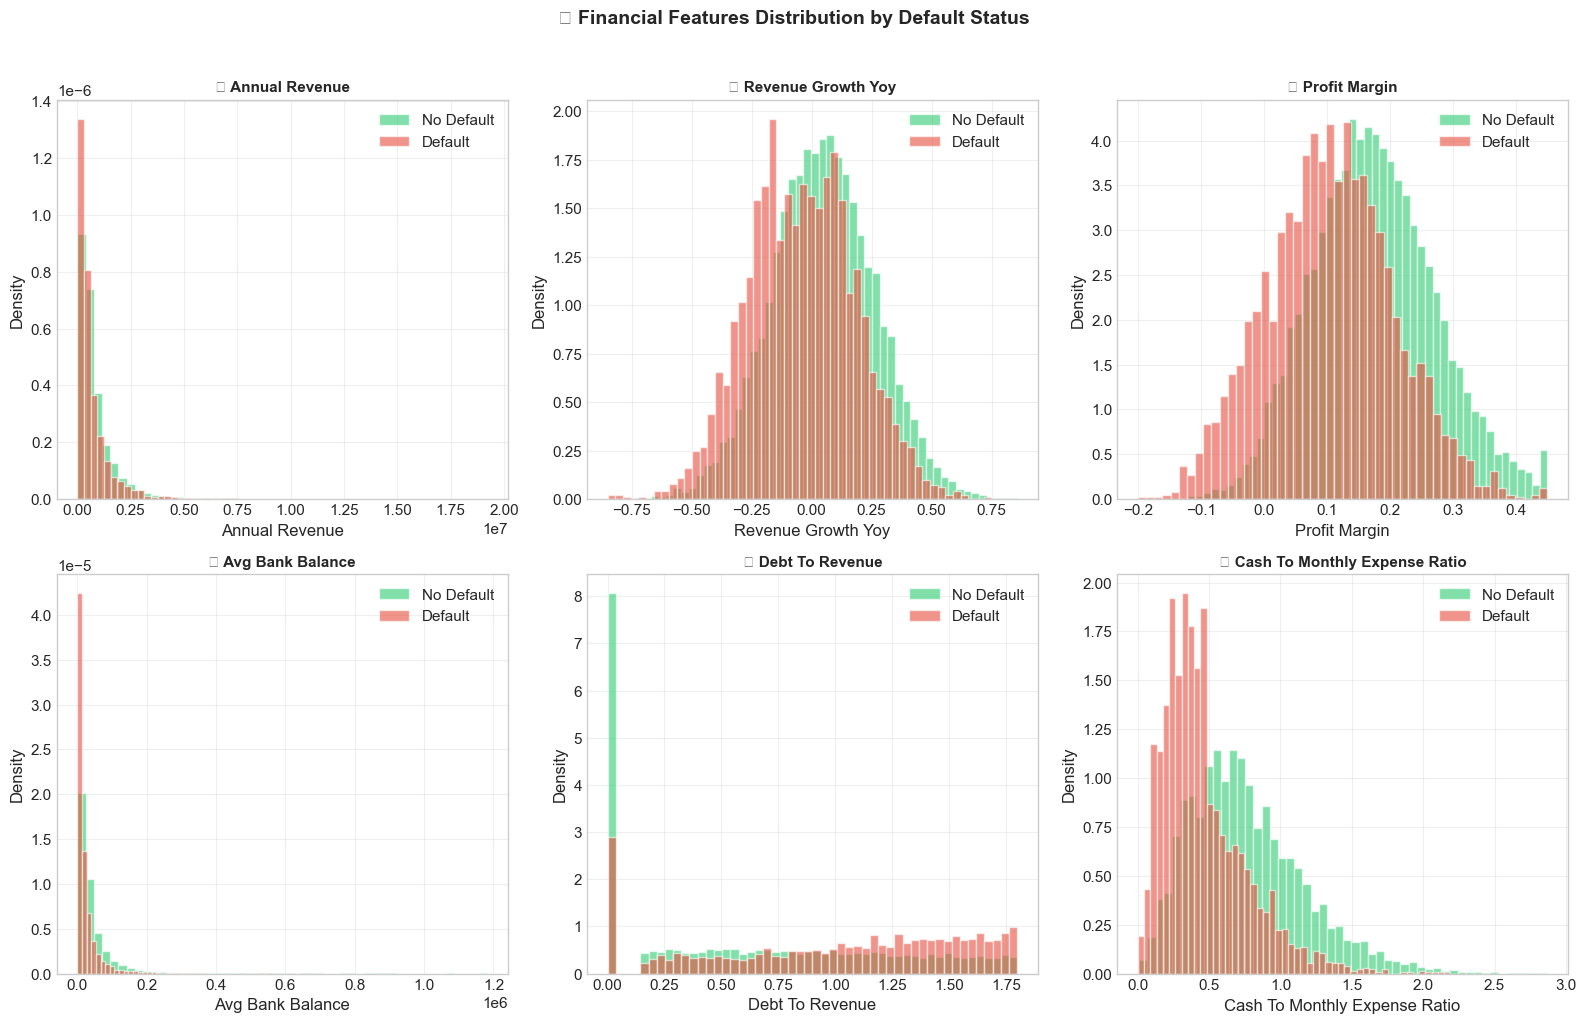

In [66]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    KEY FINANCIAL METRICS DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════════════════

# Key financial features to visualize
financial_features = [
    'annual_revenue', 'revenue_growth_yoy', 'profit_margin', 
    'avg_bank_balance', 'debt_to_revenue', 'cash_to_monthly_expense_ratio'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(financial_features):
    ax = axes[idx]
    
    # Split by default status
    data_0 = df[df['default_flag'] == 0][feature].dropna()
    data_1 = df[df['default_flag'] == 1][feature].dropna()
    
    # Plot overlapping histograms
    ax.hist(data_0, bins=50, alpha=0.6, color=RISK_COLORS['low'], 
            label='No Default', density=True, edgecolor='white')
    ax.hist(data_1, bins=50, alpha=0.6, color=RISK_COLORS['high'], 
            label='Default', density=True, edgecolor='white')
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.set_title(f'💰 {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('📊 Financial Features Distribution by Default Status', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

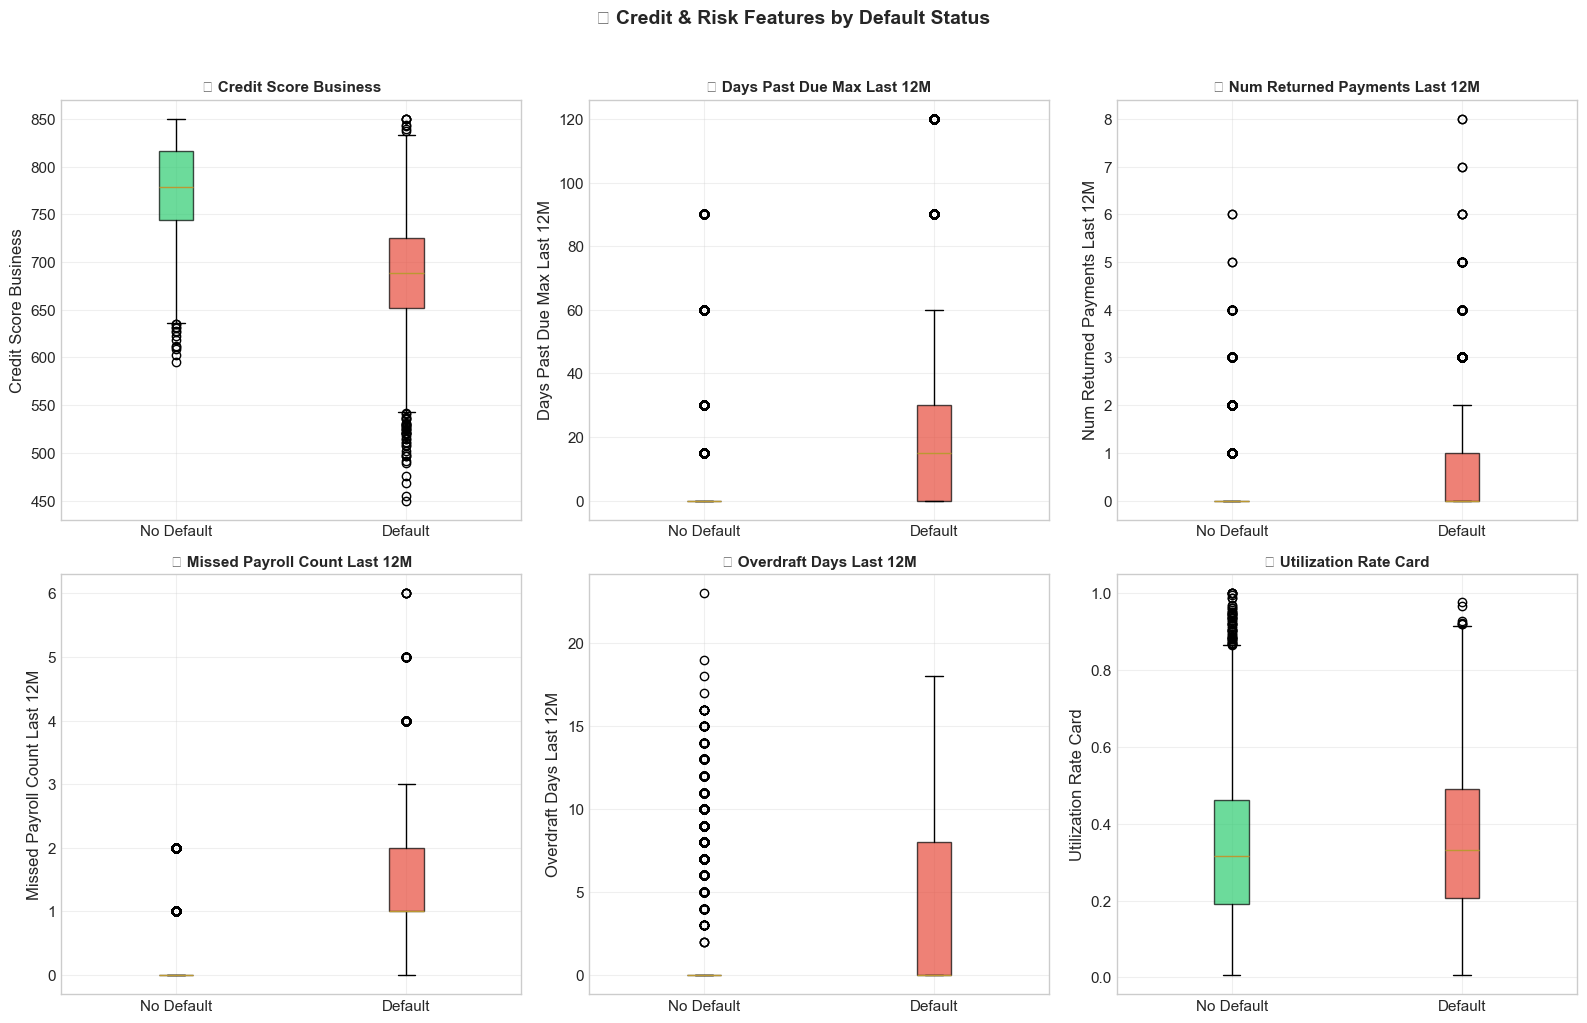

In [88]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CREDIT & RISK METRICS DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════════════════

# Credit-related features
credit_features = [
    'credit_score_business', 'days_past_due_max_last_12m', 'num_returned_payments_last_12m',
    'missed_payroll_count_last_12m', 'overdraft_days_last_12m', 'utilization_rate_card'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(credit_features):
    ax = axes[idx]
    
    # Box plot by default status
    data = [df[df['default_flag']==0][feature].dropna(), 
            df[df['default_flag']==1][feature].dropna()]
    
    bp = ax.boxplot(data, labels=['No Default', 'Default'], patch_artist=True)
    bp['boxes'][0].set_facecolor(RISK_COLORS['low'])
    bp['boxes'][1].set_facecolor(RISK_COLORS['high'])
    for box in bp['boxes']:
        box.set_alpha(0.7)
    
    ax.set_ylabel(feature.replace('_', ' ').title())
    ax.set_title(f'📋 {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('📊 Credit & Risk Features by Default Status', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

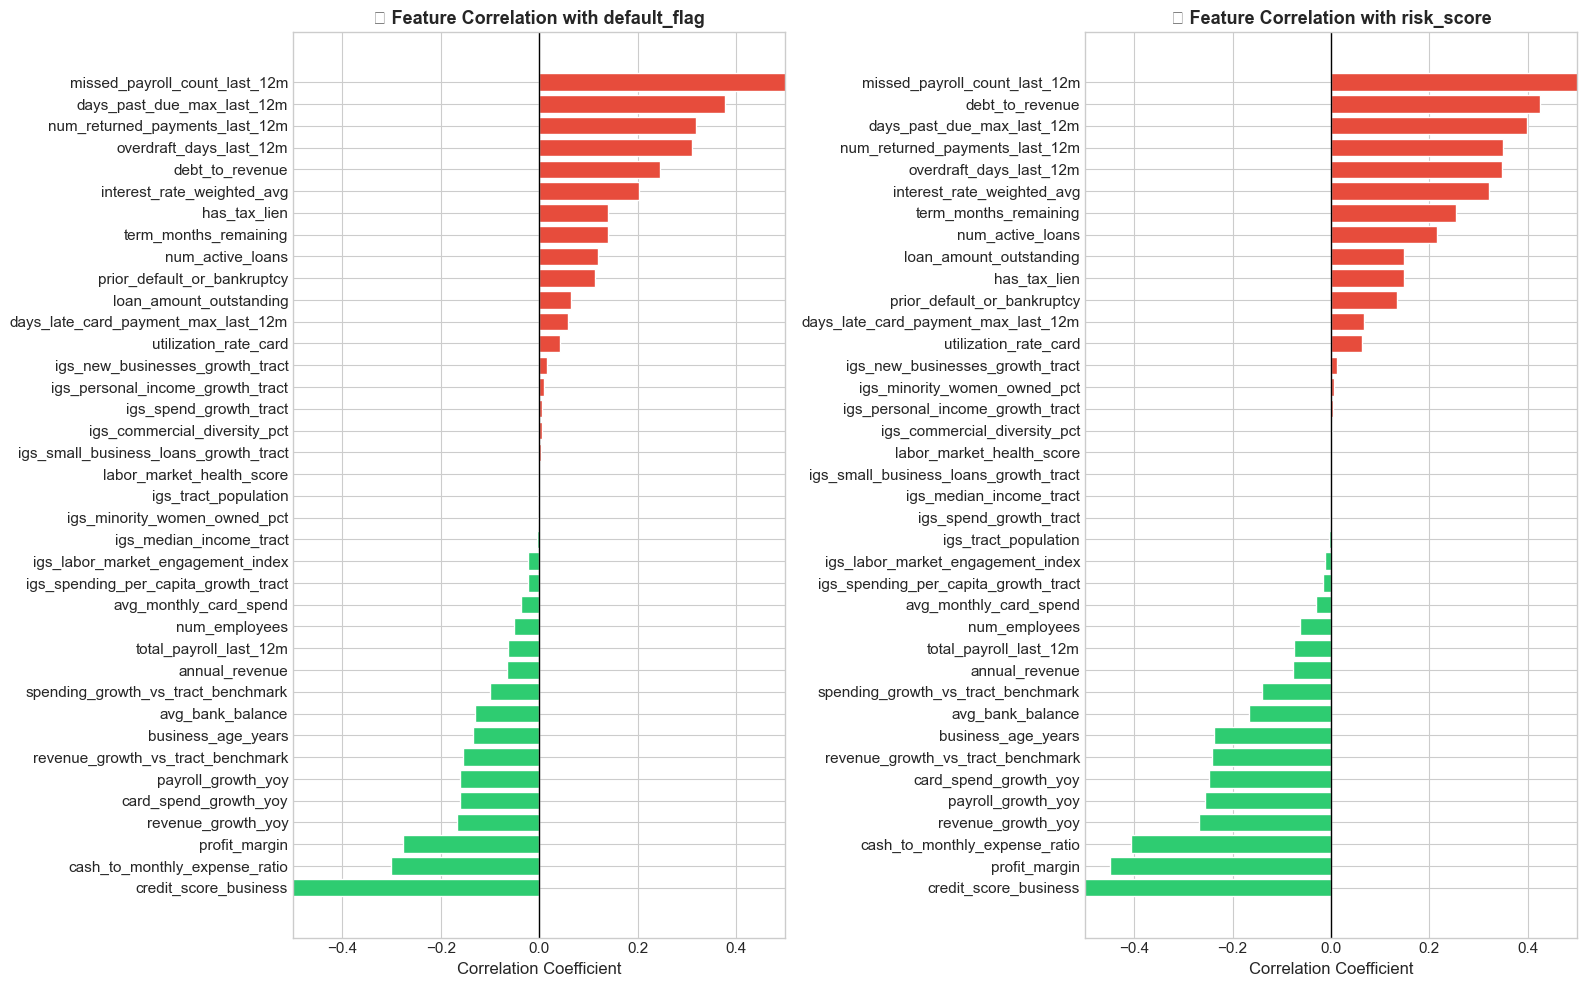


📊 Top 10 Features POSITIVELY Correlated with Default:
──────────────────────────────────────────────────
   missed_payroll_count_last_12m: 0.5912
   days_past_due_max_last_12m: 0.3771
   num_returned_payments_last_12m: 0.3188
   overdraft_days_last_12m: 0.3106
   debt_to_revenue: 0.2458
   interest_rate_weighted_avg: 0.2021
   has_tax_lien: 0.1406
   term_months_remaining: 0.1396
   num_active_loans: 0.1192
   prior_default_or_bankruptcy: 0.1125

📊 Top 10 Features NEGATIVELY Correlated with Default:
──────────────────────────────────────────────────
   credit_score_business: -0.6014
   cash_to_monthly_expense_ratio: -0.3011
   profit_margin: -0.2775
   revenue_growth_yoy: -0.1676
   card_spend_growth_yoy: -0.1618
   payroll_growth_yoy: -0.1607
   revenue_growth_vs_tract_benchmark: -0.1545
   business_age_years: -0.1349
   avg_bank_balance: -0.1305
   spending_growth_vs_tract_benchmark: -0.0997


In [89]:
# ═══════════════════════════════════════════════════════════════════════════════
#                         CORRELATION ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

# Select numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c != 'business_id']

# Calculate correlations with targets
corr_with_default = df[numerical_cols].corr()['default_flag'].drop(['default_flag', 'risk_score']).sort_values()
corr_with_risk = df[numerical_cols].corr()['risk_score'].drop(['default_flag', 'risk_score']).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# ─────────────────────────────────────────────────────────────────────────────
# Correlation with default_flag
# ─────────────────────────────────────────────────────────────────────────────
colors_corr = [RISK_COLORS['high'] if x > 0 else RISK_COLORS['low'] for x in corr_with_default.values]
axes[0].barh(corr_with_default.index, corr_with_default.values, color=colors_corr, edgecolor='white')
axes[0].axvline(x=0, color='black', linewidth=1)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('🔗 Feature Correlation with default_flag', fontsize=13, fontweight='bold')
axes[0].set_xlim(-0.5, 0.5)

# ─────────────────────────────────────────────────────────────────────────────
# Correlation with risk_score
# ─────────────────────────────────────────────────────────────────────────────
colors_corr2 = [RISK_COLORS['high'] if x > 0 else RISK_COLORS['low'] for x in corr_with_risk.values]
axes[1].barh(corr_with_risk.index, corr_with_risk.values, color=colors_corr2, edgecolor='white')
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('🔗 Feature Correlation with risk_score', fontsize=13, fontweight='bold')
axes[1].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()

# Print top correlations
print("\n📊 Top 10 Features POSITIVELY Correlated with Default:")
print("─" * 50)
for feat, corr in corr_with_default.tail(10)[::-1].items():
    print(f"   {feat}: {corr:.4f}")

print("\n📊 Top 10 Features NEGATIVELY Correlated with Default:")
print("─" * 50)
for feat, corr in corr_with_default.head(10).items():
    print(f"   {feat}: {corr:.4f}")

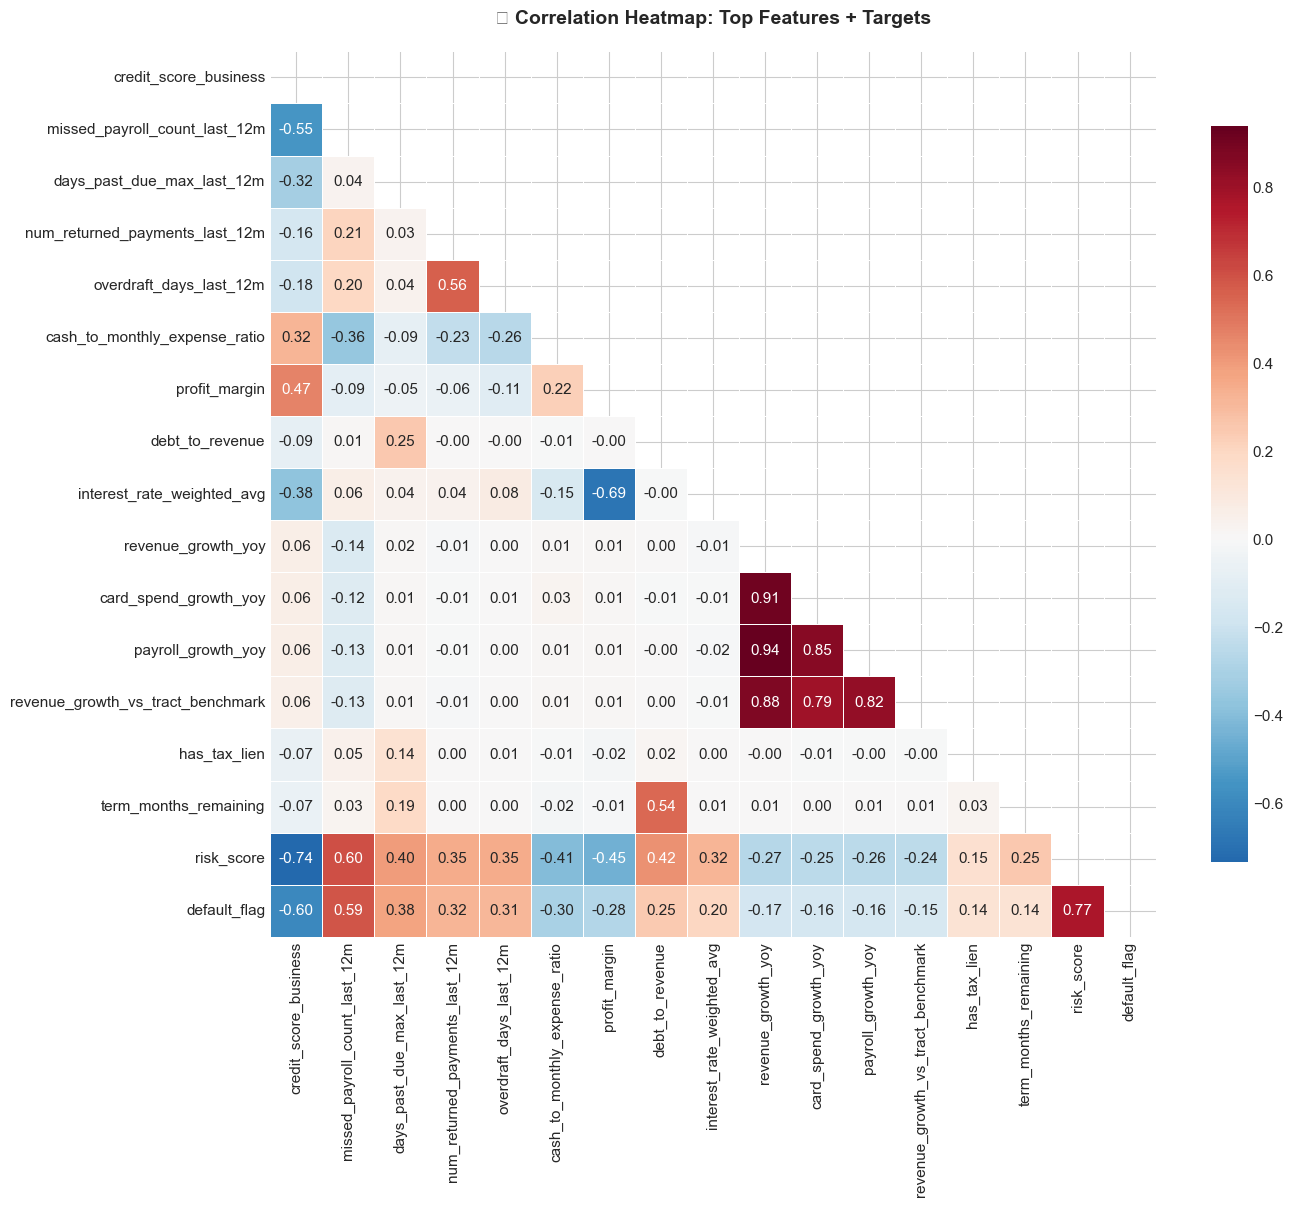

In [109]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CORRELATION HEATMAP (Top Features)
# ═══════════════════════════════════════════════════════════════════════════════

# Select top correlated features for heatmap
top_features = list(corr_with_default.abs().sort_values(ascending=False).head(15).index)
top_features = top_features + ['risk_score', 'default_flag']

corr_matrix = df[top_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})

plt.title('🔥 Correlation Heatmap: Top Features + Targets', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## ⚙️ 5. Data Preprocessing & Feature Preparation

In [128]:
# ═══════════════════════════════════════════════════════════════════════════════
#                      DEFINE FEATURE CATEGORIES
# ═══════════════════════════════════════════════════════════════════════════════

print("🛠️ FEATURE ENGINEERING & PREPROCESSING")
print("═" * 70)

# Define columns
ID_COL = 'business_id'
TARGET_COLS = ['risk_score', 'default_flag']
CATEGORICAL_COLS = ['industry_sector', 'region_parish']

# All feature columns (excluding ID and targets)
FEATURE_COLS = [col for col in df.columns if col not in [ID_COL] + TARGET_COLS]

# Numerical features (excluding categorical)
NUMERICAL_COLS = [col for col in FEATURE_COLS if col not in CATEGORICAL_COLS]

print(f"\n📊 Column Summary:")
print(f"   • ID Column: {ID_COL}")
print(f"   • Target Columns: {TARGET_COLS}")
print(f"   • Categorical Features: {len(CATEGORICAL_COLS)}")
print(f"   • Numerical Features: {len(NUMERICAL_COLS)}")
print(f"   • Total Features: {len(FEATURE_COLS)}")

🛠️ FEATURE ENGINEERING & PREPROCESSING
══════════════════════════════════════════════════════════════════════

📊 Column Summary:
   • ID Column: business_id
   • Target Columns: ['risk_score', 'default_flag']
   • Categorical Features: 2
   • Numerical Features: 38
   • Total Features: 40


In [129]:
# ═══════════════════════════════════════════════════════════════════════════════
#                      HANDLE MISSING VALUES
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🔧 Handling Missing Values...")
print("─" * 50)

# Create a copy for processing
df_processed = df.copy()

# Check missing values before
missing_before = df_processed[NUMERICAL_COLS].isnull().sum().sum()
print(f"\n   Missing values BEFORE: {missing_before:,}")

# Strategy: Fill numerical missing values with median (robust to outliers)
for col in NUMERICAL_COLS:
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"   ✔ {col}: filled with median ({median_val:.4f})")

# Check missing values after
missing_after = df_processed[NUMERICAL_COLS].isnull().sum().sum()
print(f"\n   Missing values AFTER: {missing_after}")
print("\n✅ Missing value handling complete!")


🔧 Handling Missing Values...
──────────────────────────────────────────────────

   Missing values BEFORE: 17,852
   ✔ avg_bank_balance: filled with median (21902.5800)
   ✔ cash_to_monthly_expense_ratio: filled with median (0.6300)
   ✔ total_payroll_last_12m: filled with median (204846.1950)
   ✔ missed_payroll_count_last_12m: filled with median (0.0000)
   ✔ credit_score_business: filled with median (764.0000)
   ✔ card_spend_growth_yoy: filled with median (0.0290)
   ✔ utilization_rate_card: filled with median (0.3176)

   Missing values AFTER: 0

✅ Missing value handling complete!


In [130]:
# ═══════════════════════════════════════════════════════════════════════════════
#                      ENCODE CATEGORICAL FEATURES
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🏷️ Encoding Categorical Features...")
print("─" * 50)

# Store label encoders for later use
label_encoders = {}

for col in CATEGORICAL_COLS:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    
    n_unique = len(le.classes_)
    print(f"\n   🏷️ {col}:")
    print(f"      Unique values: {n_unique}")
    print(f"      Classes: {list(le.classes_)}")

# Update feature columns to use encoded versions
FEATURE_COLS_FINAL = NUMERICAL_COLS + [col + '_encoded' for col in CATEGORICAL_COLS]

print(f"\n\n✅ Final feature count: {len(FEATURE_COLS_FINAL)}")
print(f"\n📝 Final Feature List:")
for i, col in enumerate(FEATURE_COLS_FINAL, 1):
    print(f"   {i:2d}. {col}")


🏷️ Encoding Categorical Features...
──────────────────────────────────────────────────

   🏷️ industry_sector:
      Unique values: 10
      Classes: ['Agriculture', 'Construction', 'Food Services', 'Healthcare', 'Manufacturing', 'Professional Services', 'Real Estate', 'Retail', 'Technology', 'Transportation']

   🏷️ region_parish:
      Unique values: 10
      Classes: ['Caddo', 'Calcasieu', 'East Baton Rouge', 'Jefferson', 'Lafayette', 'Orleans', 'Ouachita', 'Rapides', 'St. Tammany', 'Tangipahoa']


✅ Final feature count: 40

📝 Final Feature List:
    1. business_age_years
    2. annual_revenue
    3. revenue_growth_yoy
    4. profit_margin
    5. avg_bank_balance
    6. cash_to_monthly_expense_ratio
    7. overdraft_days_last_12m
    8. loan_amount_outstanding
    9. debt_to_revenue
   10. interest_rate_weighted_avg
   11. term_months_remaining
   12. days_past_due_max_last_12m
   13. num_active_loans
   14. num_employees
   15. total_payroll_last_12m
   16. missed_payroll_count_la

In [139]:
# ═══════════════════════════════════════════════════════════════════════════════
#                      PREPARE TRAIN/TEST SPLIT
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🔀 Preparing Train/Test Split...")
print("─" * 50)

# Define random seed for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Features matrix
X = df_processed[FEATURE_COLS_FINAL].values
feature_names = FEATURE_COLS_FINAL

# Target for Classification
y_class = df_processed['default_flag'].values

# Target for Regression
y_reg = df_processed['risk_score'].values

# Stratified split for classification (maintains class distribution)
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_class  # Stratify by default_flag to maintain class balance
)

print(f"\n   📊 Dataset Split:")
print(f"      Training set: {len(X_train):,} samples ({(1-TEST_SIZE)*100:.0f}%)")
print(f"      Test set:     {len(X_test):,} samples ({TEST_SIZE*100:.0f}%)")
print(f"\n   🎯 Classification Target (default_flag):")
print(f"      Train - Class 0: {sum(y_train_class==0):,} | Class 1: {sum(y_train_class==1):,}")
print(f"      Test  - Class 0: {sum(y_test_class==0):,} | Class 1: {sum(y_test_class==1):,}")
print(f"\n   📊 Regression Target (risk_score):")
print(f"      Train - Mean: {y_train_reg.mean():.2f} | Std: {y_train_reg.std():.2f}")
print(f"      Test  - Mean: {y_test_reg.mean():.2f} | Std: {y_test_reg.std():.2f}")

print("\n✅ Data preparation complete!")


🔀 Preparing Train/Test Split...
──────────────────────────────────────────────────

   📊 Dataset Split:
      Training set: 12,000 samples (80%)
      Test set:     3,000 samples (20%)

   🎯 Classification Target (default_flag):
      Train - Class 0: 9,486 | Class 1: 2,514
      Test  - Class 0: 2,372 | Class 1: 628

   📊 Regression Target (risk_score):
      Train - Mean: 46.58 | Std: 31.79
      Test  - Mean: 46.90 | Std: 31.55

✅ Data preparation complete!


---

## 🤖 6. XGBoost Classifier Training (default_flag)

Training a binary classifier to predict whether a business will default.

In [154]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    XGBOOST CLASSIFIER CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

print("🤖 XGBOOST CLASSIFIER TRAINING")
print("═" * 70)

# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = sum(y_train_class == 0) / sum(y_train_class == 1)
print(f"\n⚖️ Class imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"   Using scale_pos_weight={scale_pos_weight:.2f} to balance classes")

# Define classifier hyperparameters
CLASSIFIER_PARAMS = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0
}

print("\n📋 Classifier Hyperparameters:")
print("─" * 50)
for param, value in CLASSIFIER_PARAMS.items():
    print(f"   {param}: {value}")

🤖 XGBOOST CLASSIFIER TRAINING
══════════════════════════════════════════════════════════════════════

⚖️ Class imbalance ratio: 3.77:1
   Using scale_pos_weight=3.77 to balance classes

📋 Classifier Hyperparameters:
──────────────────────────────────────────────────
   n_estimators: 300
   max_depth: 6
   learning_rate: 0.1
   subsample: 0.8
   colsample_bytree: 0.8
   min_child_weight: 3
   gamma: 0.1
   reg_alpha: 0.1
   reg_lambda: 1.0
   scale_pos_weight: 3.7732696897374702
   objective: binary:logistic
   eval_metric: auc
   random_state: 42
   n_jobs: -1
   verbosity: 0


In [157]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    TRAIN CLASSIFIER WITH CROSS-VALIDATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🏋️ Training XGBoost Classifier...")
print("─" * 50)

# Initialize classifier
xgb_classifier = XGBClassifier(**CLASSIFIER_PARAMS)

# Cross-validation
print("\n   🔄 Performing 5-Fold Stratified Cross-Validation...")
cv_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores_roc = cross_val_score(xgb_classifier, X_train, y_train_class, 
                                 cv=cv_classifier, scoring='roc_auc', n_jobs=-1)
cv_scores_f1 = cross_val_score(xgb_classifier, X_train, y_train_class, 
                                cv=cv_classifier, scoring='f1', n_jobs=-1)

print(f"\n   📊 Cross-Validation Results:")
print(f"      ROC-AUC: {cv_scores_roc.mean():.4f} (+/- {cv_scores_roc.std()*2:.4f})")
print(f"      F1 Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std()*2:.4f})")

# Train final model on full training set
print("\n   🚀 Training final model on full training set...")
xgb_classifier.fit(X_train, y_train_class, 
                   eval_set=[(X_train, y_train_class), (X_test, y_test_class)],
                   verbose=False)

print("\n✅ Classifier training complete!")


🏋️ Training XGBoost Classifier...
──────────────────────────────────────────────────

   🔄 Performing 5-Fold Stratified Cross-Validation...

   📊 Cross-Validation Results:
      ROC-AUC: 0.9902 (+/- 0.0021)
      F1 Score: 0.9090 (+/- 0.0138)

   🚀 Training final model on full training set...

✅ Classifier training complete!


In [170]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CLASSIFIER EVALUATION ON TEST SET
# ═══════════════════════════════════════════════════════════════════════════════

print("\n📊 CLASSIFIER EVALUATION (Test Set)")
print("═" * 70)

# Get predictions
y_pred_class = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
roc_auc = roc_auc_score(y_test_class, y_pred_proba)
avg_precision = average_precision_score(y_test_class, y_pred_proba)

print("\n   🏆 Test Set Performance:")
print("   ─" * 40)
print(f"      Accuracy:          {accuracy:.4f}")
print(f"      Precision:         {precision:.4f}")
print(f"      Recall:            {recall:.4f}")
print(f"      F1 Score:          {f1:.4f}")
print(f"      ROC-AUC:           {roc_auc:.4f}")
print(f"      Avg Precision:     {avg_precision:.4f}")

# Classification Report
print("\n   📋 Classification Report:")
print("   ─" * 40)
print(classification_report(y_test_class, y_pred_class, target_names=['No Default', 'Default']))


📊 CLASSIFIER EVALUATION (Test Set)
══════════════════════════════════════════════════════════════════════

   🏆 Test Set Performance:
   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─
      Accuracy:          0.9690
      Precision:         0.9173
      Recall:            0.9363
      F1 Score:          0.9267
      ROC-AUC:           0.9925
      Avg Precision:     0.9805

   📋 Classification Report:
   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─
              precision    recall  f1-score   support

  No Default       0.98      0.98      0.98      2372
     Default       0.92      0.94      0.93       628

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3

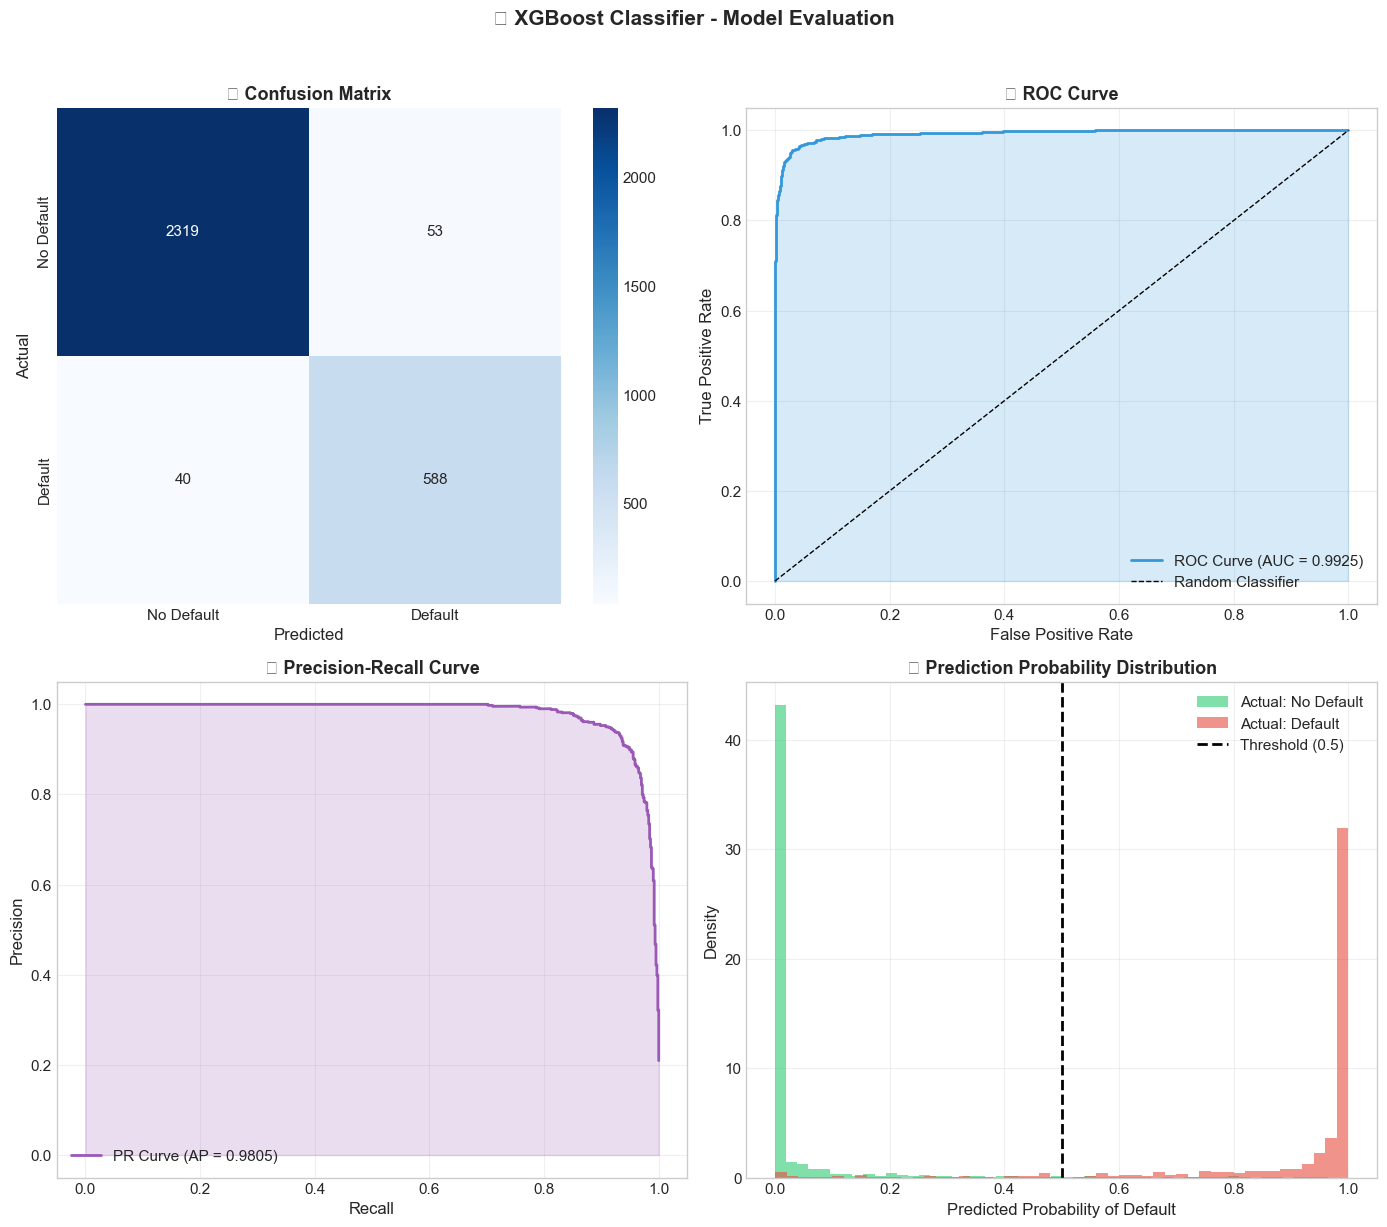

In [176]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CLASSIFIER VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ─────────────────────────────────────────────────────────────────────────────
# 1. Confusion Matrix
# ─────────────────────────────────────────────────────────────────────────────
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Default', 'Default'], 
            yticklabels=['No Default', 'Default'])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('🎯 Confusion Matrix', fontsize=13, fontweight='bold')

# ─────────────────────────────────────────────────────────────────────────────
# 2. ROC Curve
# ─────────────────────────────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred_proba)
axes[0, 1].plot(fpr, tpr, color=RISK_COLORS['primary'], linewidth=2, 
                label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].fill_between(fpr, tpr, alpha=0.2, color=RISK_COLORS['primary'])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('📈 ROC Curve', fontsize=13, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Precision-Recall Curve
# ─────────────────────────────────────────────────────────────────────────────
precision_curve, recall_curve, _ = precision_recall_curve(y_test_class, y_pred_proba)
axes[1, 0].plot(recall_curve, precision_curve, color=RISK_COLORS['secondary'], linewidth=2,
                label=f'PR Curve (AP = {avg_precision:.4f})')
axes[1, 0].fill_between(recall_curve, precision_curve, alpha=0.2, color=RISK_COLORS['secondary'])
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('📉 Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[1, 0].legend(loc='lower left')
axes[1, 0].grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Prediction Probability Distribution
# ─────────────────────────────────────────────────────────────────────────────
axes[1, 1].hist(y_pred_proba[y_test_class==0], bins=50, alpha=0.6, 
                color=RISK_COLORS['low'], label='Actual: No Default', density=True)
axes[1, 1].hist(y_pred_proba[y_test_class==1], bins=50, alpha=0.6, 
                color=RISK_COLORS['high'], label='Actual: Default', density=True)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1, 1].set_xlabel('Predicted Probability of Default')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('📊 Prediction Probability Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('🤖 XGBoost Classifier - Model Evaluation', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 📊 7. XGBoost Regressor Training (risk_score)

Training a regressor to predict the continuous risk score (0-100).

In [186]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    XGBOOST REGRESSOR CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

print("📊 XGBOOST REGRESSOR TRAINING")
print("═" * 70)

# Define regressor hyperparameters
REGRESSOR_PARAMS = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0
}

print("\n📋 Regressor Hyperparameters:")
print("─" * 50)
for param, value in REGRESSOR_PARAMS.items():
    print(f"   {param}: {value}")

📊 XGBOOST REGRESSOR TRAINING
══════════════════════════════════════════════════════════════════════

📋 Regressor Hyperparameters:
──────────────────────────────────────────────────
   n_estimators: 300
   max_depth: 6
   learning_rate: 0.1
   subsample: 0.8
   colsample_bytree: 0.8
   min_child_weight: 3
   gamma: 0.1
   reg_alpha: 0.1
   reg_lambda: 1.0
   objective: reg:squarederror
   eval_metric: rmse
   random_state: 42
   n_jobs: -1
   verbosity: 0


In [173]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    TRAIN REGRESSOR WITH CROSS-VALIDATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🏋️ Training XGBoost Regressor...")
print("─" * 50)

# Initialize regressor
xgb_regressor = XGBRegressor(**REGRESSOR_PARAMS)

# Cross-validation
print("\n   🔄 Performing 5-Fold Cross-Validation...")
cv_regressor = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores_r2 = cross_val_score(xgb_regressor, X_train, y_train_reg, 
                                cv=cv_regressor, scoring='r2', n_jobs=-1)
cv_scores_mae = cross_val_score(xgb_regressor, X_train, y_train_reg, 
                                 cv=cv_regressor, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"\n   📊 Cross-Validation Results:")
print(f"      R² Score: {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std()*2:.4f})")
print(f"      MAE: {-cv_scores_mae.mean():.4f} (+/- {cv_scores_mae.std()*2:.4f})")

# Train final model on full training set
print("\n   🚀 Training final model on full training set...")
xgb_regressor.fit(X_train, y_train_reg,
                  eval_set=[(X_train, y_train_reg), (X_test, y_test_reg)],
                  verbose=False)

print("\n✅ Regressor training complete!")


🏋️ Training XGBoost Regressor...
──────────────────────────────────────────────────

   🔄 Performing 5-Fold Cross-Validation...

   📊 Cross-Validation Results:
      R² Score: 0.9608 (+/- 0.0044)
      MAE: 4.1533 (+/- 0.1780)

   🚀 Training final model on full training set...

✅ Regressor training complete!


In [188]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    REGRESSOR EVALUATION ON TEST SET
# ═══════════════════════════════════════════════════════════════════════════════

print("\n📊 REGRESSOR EVALUATION (Test Set)")
print("═" * 70)

# Get predictions
y_pred_reg = xgb_regressor.predict(X_test)

# Clip predictions to valid range [0, 100]
y_pred_reg_clipped = np.clip(y_pred_reg, 0, 100)

# Calculate metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg_clipped)
mse = mean_squared_error(y_test_reg, y_pred_reg_clipped)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg_clipped)

print("\n   🏆 Test Set Performance:")
print("   ─" * 40)
print(f"      MAE (Mean Absolute Error):     {mae:.4f}")
print(f"      MSE (Mean Squared Error):      {mse:.4f}")
print(f"      RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"      R² Score:                       {r2:.4f}")

# Additional insights
print("\n   📊 Prediction Statistics:")
print("   ─" * 40)
print(f"      Actual    - Mean: {y_test_reg.mean():.2f} | Std: {y_test_reg.std():.2f}")
print(f"      Predicted - Mean: {y_pred_reg_clipped.mean():.2f} | Std: {y_pred_reg_clipped.std():.2f}")
print(f"      Correlation: {np.corrcoef(y_test_reg, y_pred_reg_clipped)[0,1]:.4f}")


📊 REGRESSOR EVALUATION (Test Set)
══════════════════════════════════════════════════════════════════════

   🏆 Test Set Performance:
   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─
      MAE (Mean Absolute Error):     3.6300
      MSE (Mean Squared Error):      34.4477
      RMSE (Root Mean Squared Error): 5.8692
      R² Score:                       0.9654

   📊 Prediction Statistics:
   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─   ─
      Actual    - Mean: 46.90 | Std: 31.55
      Predicted - Mean: 46.74 | Std: 30.22
      Correlation: 0.9829


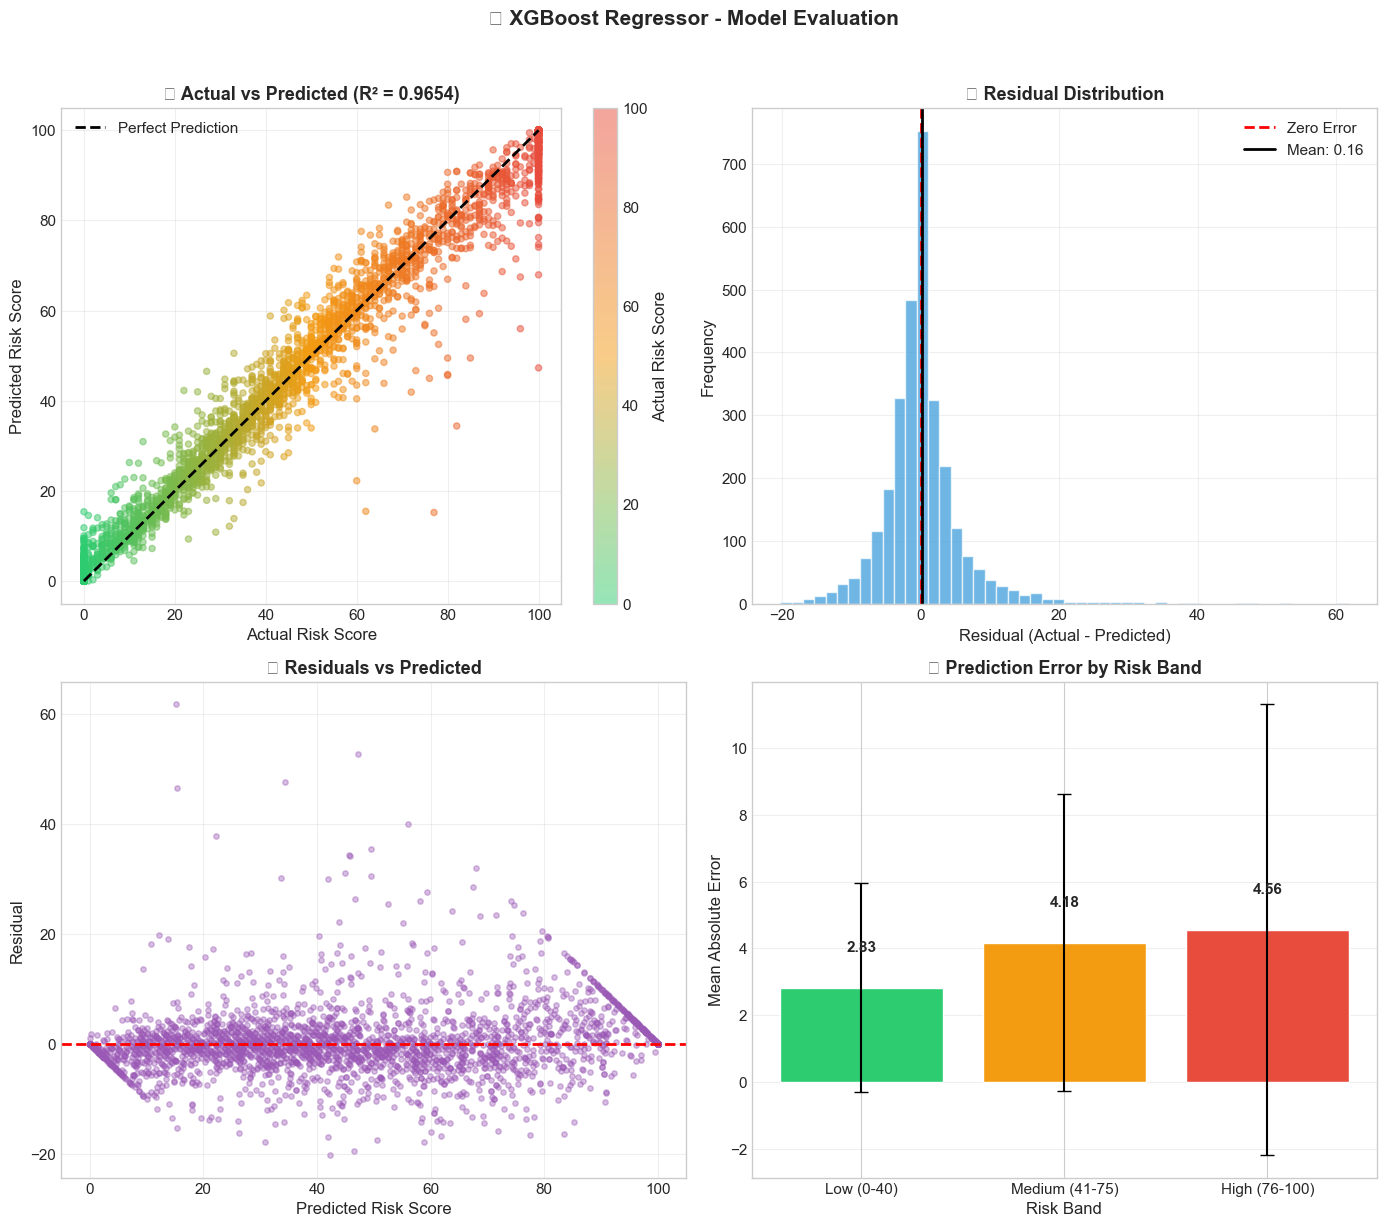

In [198]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    REGRESSOR VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ─────────────────────────────────────────────────────────────────────────────
# 1. Actual vs Predicted Scatter Plot
# ─────────────────────────────────────────────────────────────────────────────
scatter = axes[0, 0].scatter(y_test_reg, y_pred_reg_clipped, 
                              c=y_test_reg, cmap=risk_cmap, alpha=0.5, s=20)
axes[0, 0].plot([0, 100], [0, 100], 'k--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Risk Score')
axes[0, 0].set_ylabel('Predicted Risk Score')
axes[0, 0].set_title(f'🎯 Actual vs Predicted (R² = {r2:.4f})', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_xlim(-5, 105)
axes[0, 0].set_ylim(-5, 105)
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Actual Risk Score')

# ─────────────────────────────────────────────────────────────────────────────
# 2. Residual Distribution
# ─────────────────────────────────────────────────────────────────────────────
residuals = y_test_reg - y_pred_reg_clipped
axes[0, 1].hist(residuals, bins=50, color=RISK_COLORS['primary'], 
                edgecolor='white', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=residuals.mean(), color='black', linestyle='-', linewidth=2, 
                   label=f'Mean: {residuals.mean():.2f}')
axes[0, 1].set_xlabel('Residual (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('📊 Residual Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Residuals vs Predicted
# ─────────────────────────────────────────────────────────────────────────────
axes[1, 0].scatter(y_pred_reg_clipped, residuals, alpha=0.4, s=15, c=RISK_COLORS['secondary'])
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Risk Score')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('📉 Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Error by Risk Band
# ─────────────────────────────────────────────────────────────────────────────
risk_bands_test = pd.cut(y_test_reg, bins=[-1, 40, 75, 100], 
                          labels=['Low (0-40)', 'Medium (41-75)', 'High (76-100)'])

resid_by_band = pd.DataFrame({'residual': np.abs(residuals), 'band': risk_bands_test})
band_errors = resid_by_band.groupby('band')['residual'].agg(['mean', 'std'])

colors_band = [RISK_COLORS['low'], RISK_COLORS['medium'], RISK_COLORS['high']]
bars = axes[1, 1].bar(band_errors.index, band_errors['mean'], 
                       yerr=band_errors['std'], color=colors_band, 
                       edgecolor='white', capsize=5)
axes[1, 1].set_xlabel('Risk Band')
axes[1, 1].set_ylabel('Mean Absolute Error')
axes[1, 1].set_title('🎯 Prediction Error by Risk Band', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, mae_val in zip(bars, band_errors['mean']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{mae_val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('📊 XGBoost Regressor - Model Evaluation', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 🌟 8. Feature Importance Analysis

🌟 FEATURE IMPORTANCE ANALYSIS
══════════════════════════════════════════════════════════════════════


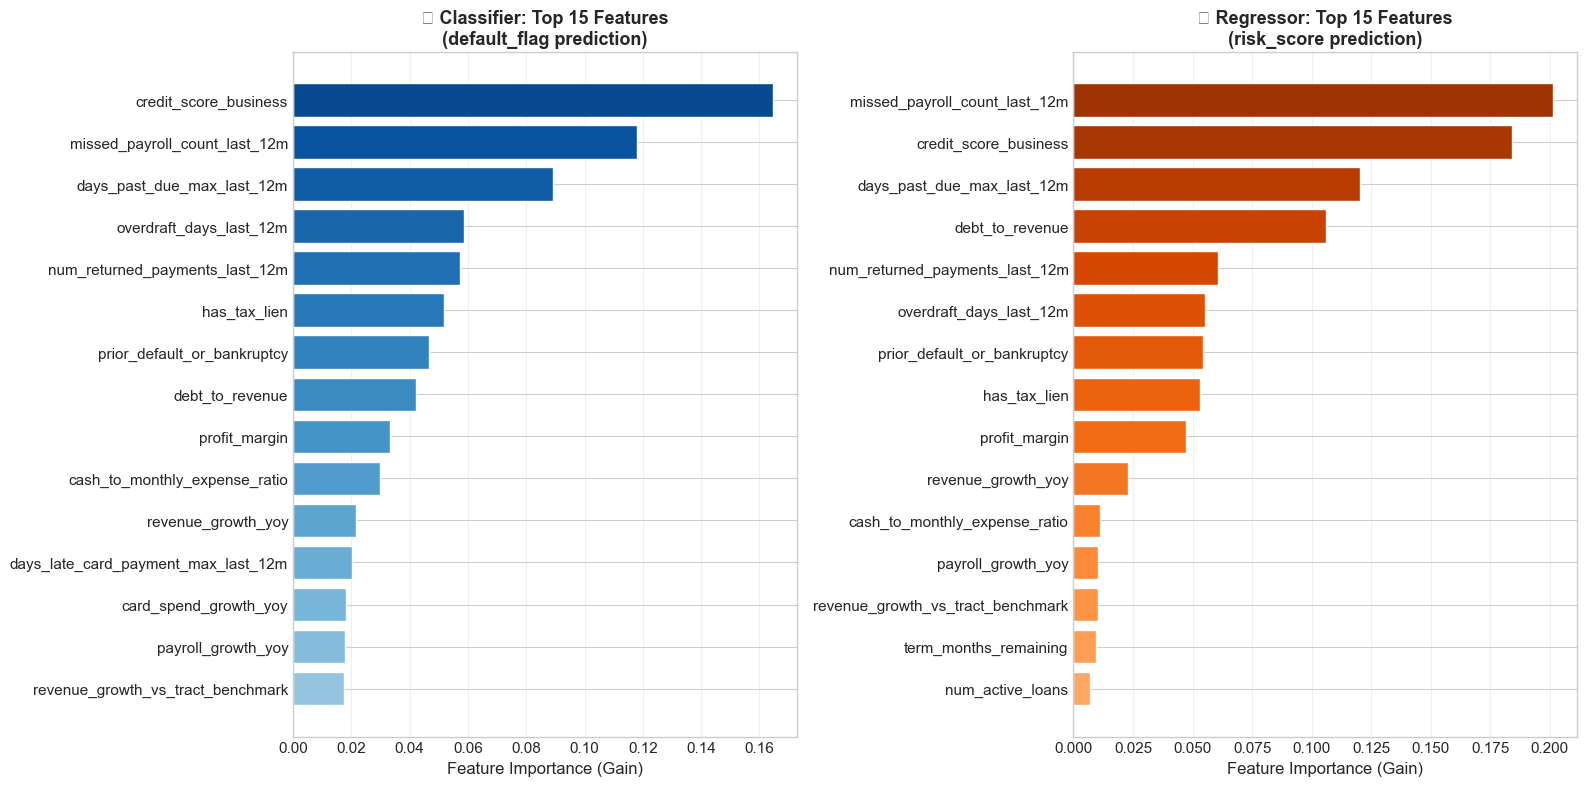


🏆 Top 10 Features for Classifier (default_flag):
──────────────────────────────────────────────────
    1. credit_score_business: 0.1646
    2. missed_payroll_count_last_12m: 0.1178
    3. days_past_due_max_last_12m: 0.0892
    4. overdraft_days_last_12m: 0.0587
    5. num_returned_payments_last_12m: 0.0571
    6. has_tax_lien: 0.0519
    7. prior_default_or_bankruptcy: 0.0468
    8. debt_to_revenue: 0.0421
    9. profit_margin: 0.0332
   10. cash_to_monthly_expense_ratio: 0.0299

🏆 Top 10 Features for Regressor (risk_score):
──────────────────────────────────────────────────
    1. missed_payroll_count_last_12m: 0.2013
    2. credit_score_business: 0.1840
    3. days_past_due_max_last_12m: 0.1201
    4. debt_to_revenue: 0.1060
    5. num_returned_payments_last_12m: 0.0608
    6. overdraft_days_last_12m: 0.0552
    7. prior_default_or_bankruptcy: 0.0543
    8. has_tax_lien: 0.0531
    9. profit_margin: 0.0474
   10. revenue_growth_yoy: 0.0229


In [207]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    FEATURE IMPORTANCE COMPARISON
# ═══════════════════════════════════════════════════════════════════════════════

print("🌟 FEATURE IMPORTANCE ANALYSIS")
print("═" * 70)

# Get feature importances from both models
classifier_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

regressor_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 features for each model
top_n = 15

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ─────────────────────────────────────────────────────────────────────────────
# Classifier Feature Importance
# ─────────────────────────────────────────────────────────────────────────────
top_class = classifier_importance.head(top_n).iloc[::-1]
colors = plt.cm.Blues(np.linspace(0.4, 0.9, top_n))
axes[0].barh(top_class['feature'], top_class['importance'], color=colors, edgecolor='white')
axes[0].set_xlabel('Feature Importance (Gain)')
axes[0].set_title('🤖 Classifier: Top 15 Features\n(default_flag prediction)', 
                   fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# ─────────────────────────────────────────────────────────────────────────────
# Regressor Feature Importance
# ─────────────────────────────────────────────────────────────────────────────
top_reg = regressor_importance.head(top_n).iloc[::-1]
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, top_n))
axes[1].barh(top_reg['feature'], top_reg['importance'], color=colors, edgecolor='white')
axes[1].set_xlabel('Feature Importance (Gain)')
axes[1].set_title('📊 Regressor: Top 15 Features\n(risk_score prediction)', 
                   fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top features
print("\n🏆 Top 10 Features for Classifier (default_flag):")
print("─" * 50)
for i, row in classifier_importance.head(10).iterrows():
    print(f"   {classifier_importance.head(10).index.tolist().index(i)+1:2d}. {row['feature']}: {row['importance']:.4f}")

print("\n🏆 Top 10 Features for Regressor (risk_score):")
print("─" * 50)
for i, row in regressor_importance.head(10).iterrows():
    print(f"   {regressor_importance.head(10).index.tolist().index(i)+1:2d}. {row['feature']}: {row['importance']:.4f}")

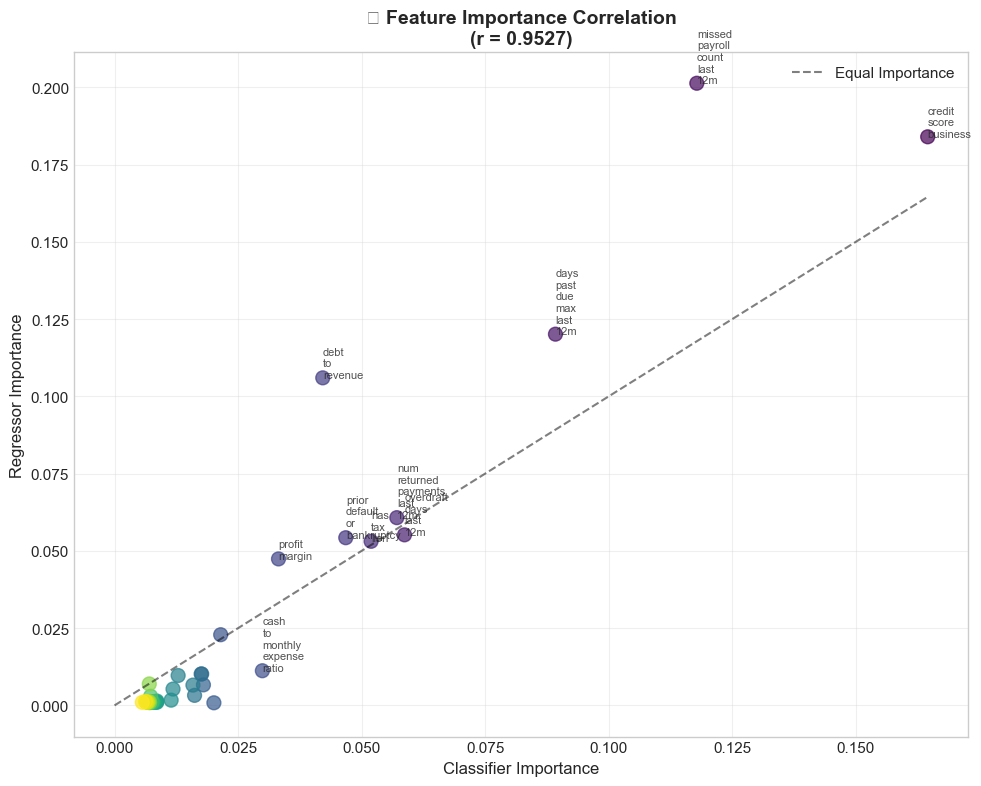


📊 Feature importance correlation between models: 0.9527


In [208]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    FEATURE IMPORTANCE CORRELATION
# ═══════════════════════════════════════════════════════════════════════════════

# Merge importances to compare
importance_comparison = classifier_importance.merge(
    regressor_importance, on='feature', suffixes=('_classifier', '_regressor')
)

# Calculate correlation between importances
importance_corr = importance_comparison['importance_classifier'].corr(
    importance_comparison['importance_regressor']
)

plt.figure(figsize=(10, 8))
plt.scatter(importance_comparison['importance_classifier'], 
            importance_comparison['importance_regressor'],
            c=range(len(importance_comparison)), cmap='viridis', s=100, alpha=0.7)

# Add feature labels for top features
for _, row in importance_comparison.nlargest(10, 'importance_classifier').iterrows():
    plt.annotate(row['feature'].replace('_', '\n'), 
                 (row['importance_classifier'], row['importance_regressor']),
                 fontsize=8, alpha=0.8)

plt.plot([0, importance_comparison['importance_classifier'].max()], 
         [0, importance_comparison['importance_classifier'].max()], 
         'k--', alpha=0.5, label='Equal Importance')

plt.xlabel('Classifier Importance', fontsize=12)
plt.ylabel('Regressor Importance', fontsize=12)
plt.title(f'🔗 Feature Importance Correlation\n(r = {importance_corr:.4f})', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Feature importance correlation between models: {importance_corr:.4f}")

---

## 💾 9. Save Models & Artifacts

In [209]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CREATE OUTPUT DIRECTORY
# ═══════════════════════════════════════════════════════════════════════════════

print("💾 SAVING MODELS & ARTIFACTS")
print("═" * 70)

# Create models directory (relative path from notebooks folder)
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"\n📁 Output directory: {MODEL_DIR}")

💾 SAVING MODELS & ARTIFACTS
══════════════════════════════════════════════════════════════════════

📁 Output directory: ../models


In [210]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    SAVE MODELS AS PICKLE FILES
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🚀 Saving trained models...")
print("─" * 50)

# Save Classifier
classifier_path = os.path.join(MODEL_DIR, 'xgboost_classifier.pkl')
with open(classifier_path, 'wb') as f:
    pickle.dump(xgb_classifier, f)
print(f"   ✔ Classifier saved: {classifier_path}")

# Save Regressor
regressor_path = os.path.join(MODEL_DIR, 'xgboost_regressor.pkl')
with open(regressor_path, 'wb') as f:
    pickle.dump(xgb_regressor, f)
print(f"   ✔ Regressor saved: {regressor_path}")

# Save Feature Names
feature_names_path = os.path.join(MODEL_DIR, 'feature_names.pkl')
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_names, f)
print(f"   ✔ Feature names saved: {feature_names_path}")

# Save Label Encoders
encoders_path = os.path.join(MODEL_DIR, 'label_encoders.pkl')
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"   ✔ Label encoders saved: {encoders_path}")

print("\n✅ All models and artifacts saved successfully!")


🚀 Saving trained models...
──────────────────────────────────────────────────
   ✔ Classifier saved: ../models/xgboost_classifier.pkl
   ✔ Regressor saved: ../models/xgboost_regressor.pkl
   ✔ Feature names saved: ../models/feature_names.pkl
   ✔ Label encoders saved: ../models/label_encoders.pkl

✅ All models and artifacts saved successfully!


In [211]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    SAVE MODEL METADATA
# ═══════════════════════════════════════════════════════════════════════════════

import json

model_metadata = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(df),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'n_features': len(feature_names),
    'feature_names': feature_names,
    'xgboost_version': xgb.__version__,
    'classifier': {
        'params': CLASSIFIER_PARAMS,
        'cv_roc_auc_mean': float(cv_scores_roc.mean()),
        'cv_roc_auc_std': float(cv_scores_roc.std()),
        'test_roc_auc': float(roc_auc),
        'test_f1': float(f1),
        'test_precision': float(precision),
        'test_recall': float(recall)
    },
    'regressor': {
        'params': REGRESSOR_PARAMS,
        'cv_r2_mean': float(cv_scores_r2.mean()),
        'cv_r2_std': float(cv_scores_r2.std()),
        'test_r2': float(r2),
        'test_mae': float(mae),
        'test_rmse': float(rmse)
    }
}

metadata_path = os.path.join(MODEL_DIR, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"\n📝 Metadata saved: {metadata_path}")


📝 Metadata saved: ../models/model_metadata.json


In [212]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    VERIFY SAVED MODELS
# ═══════════════════════════════════════════════════════════════════════════════

print("\n🔍 Verifying saved models...")
print("─" * 50)

# Load and verify classifier
with open(classifier_path, 'rb') as f:
    loaded_classifier = pickle.load(f)
y_verify_class = loaded_classifier.predict(X_test[:5])
print(f"   ✔ Classifier loaded and verified")
print(f"      Sample predictions: {y_verify_class}")

# Load and verify regressor
with open(regressor_path, 'rb') as f:
    loaded_regressor = pickle.load(f)
y_verify_reg = loaded_regressor.predict(X_test[:5])
print(f"   ✔ Regressor loaded and verified")
print(f"      Sample predictions: {np.round(y_verify_reg, 2)}")

print("\n✅ All models verified successfully!")


🔍 Verifying saved models...
──────────────────────────────────────────────────
   ✔ Classifier loaded and verified
      Sample predictions: [1 1 0 0 1]
   ✔ Regressor loaded and verified
      Sample predictions: [78.88 78.38 28.3   9.35 96.68]

✅ All models verified successfully!


---

## 📝 10. Training Summary

In [213]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    FINAL TRAINING SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

print("\n")
print("╔" + "═" * 70 + "╗")
print("║" + " " * 20 + "🏆 TRAINING COMPLETE! 🏆" + " " * 20 + "║")
print("╠" + "═" * 70 + "╣")
print("║" + " " * 70 + "║")
print(f"║  📅 Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S'):<51}║")
print(f"║  📊 Dataset Size: {len(df):,} businesses{' ' * 41}║")
print(f"║  🎯 Features Used: {len(feature_names)} features{' ' * 42}║")
print("║" + " " * 70 + "║")
print("╠" + "═" * 70 + "╣")
print("║" + " 🤖 CLASSIFIER (default_flag)" + " " * 42 + "║")
print("║" + "─" * 70 + "║")
print(f"║     Cross-Val ROC-AUC: {cv_scores_roc.mean():.4f} (±{cv_scores_roc.std()*2:.4f}){' ' * 29}║")
print(f"║     Test ROC-AUC:      {roc_auc:.4f}{' ' * 42}║")
print(f"║     Test F1 Score:     {f1:.4f}{' ' * 42}║")
print(f"║     Test Precision:    {precision:.4f}{' ' * 42}║")
print(f"║     Test Recall:       {recall:.4f}{' ' * 42}║")
print("║" + " " * 70 + "║")
print("╠" + "═" * 70 + "╣")
print("║" + " 📊 REGRESSOR (risk_score)" + " " * 45 + "║")
print("║" + "─" * 70 + "║")
print(f"║     Cross-Val R²:     {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std()*2:.4f}){' ' * 30}║")
print(f"║     Test R²:          {r2:.4f}{' ' * 42}║")
print(f"║     Test MAE:         {mae:.4f}{' ' * 42}║")
print(f"║     Test RMSE:        {rmse:.4f}{' ' * 42}║")
print("║" + " " * 70 + "║")
print("╠" + "═" * 70 + "╣")
print("║" + " 💾 SAVED ARTIFACTS" + " " * 51 + "║")
print("║" + "─" * 70 + "║")
print(f"║     • xgboost_classifier.pkl{' ' * 44}║")
print(f"║     • xgboost_regressor.pkl{' ' * 45}║")
print(f"║     • feature_names.pkl{' ' * 48}║")
print(f"║     • label_encoders.pkl{' ' * 47}║")
print(f"║     • model_metadata.json{' ' * 46}║")
print("║" + " " * 70 + "║")
print("╚" + "═" * 70 + "╝")
print("\n🚀 Models are ready for production deployment!")



╔══════════════════════════════════════════════════════════════════════╗
║                    🏆 TRAINING COMPLETE! 🏆                    ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📅 Training Date: 2025-12-01 23:19:20                                ║
║  📊 Dataset Size: 15,000 businesses                                         ║
║  🎯 Features Used: 40 features                                          ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ 🤖 CLASSIFIER (default_flag)                                          ║
║──────────────────────────────────────────────────────────────────────║
║     Cross-Val ROC-AUC: 0.9902 (±0.0021)                             ║
║     Test ROC-AUC:      0.9925                                          ║
║     Test F1 Score:     0.9267                 

---

## 📚 Usage Example

Here's how to load and use the trained models in production:

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    PRODUCTION USAGE EXAMPLE
# ═══════════════════════════════════════════════════════════════════════════════

"""
# How to load and use the models in production:

import pickle
import numpy as np

# Load models
with open('models/xgboost_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
with open('models/xgboost_regressor.pkl', 'rb') as f:
    regressor = pickle.load(f)
    
with open('models/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)
    
with open('models/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Prepare new business data (43 features)
new_business = np.array([...])  # Your feature values

# Get predictions
default_probability = classifier.predict_proba(new_business.reshape(1, -1))[0, 1]
default_flag = classifier.predict(new_business.reshape(1, -1))[0]
risk_score = np.clip(regressor.predict(new_business.reshape(1, -1))[0], 0, 100)

# Determine risk band
if risk_score < 40:
    risk_band = "Low"
elif risk_score < 75:
    risk_band = "Medium"
else:
    risk_band = "High"

print(f"Default Probability: {default_probability:.2%}")
print(f"Default Flag: {default_flag}")
print(f"Risk Score: {risk_score:.1f}")
print(f"Risk Band: {risk_band}")
"""

print("✅ Example code shown above (as docstring)")
print("\n🎉 Notebook execution complete!")

✅ Example code shown above (as docstring)

🎉 Notebook execution complete!


---

## 📄 11. Generate Sample Submission File

Generate a test dataset with predictions from both models for submission/validation.

In [234]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    GENERATE SAMPLE TEST DATA FROM ACTUAL DATASET
# ═══════════════════════════════════════════════════════════════════════════════

print("📄 GENERATING SAMPLE SUBMISSION FILE")
print("═" * 70)

# Sample from the ACTUAL dataset (not synthetic/made-up values)
N_SAMPLES = 50

np.random.seed(42)

# Randomly sample businesses from the original dataset
test_indices = np.random.choice(len(df), size=N_SAMPLES, replace=False)
test_df = df.iloc[test_indices].copy().reset_index(drop=True)

# Create new business IDs for the test set
test_df['business_id'] = [f'TEST_{i+1:04d}' for i in range(N_SAMPLES)]

print(f"\n✅ Sampled {N_SAMPLES} businesses from actual dataset")
print(f"\n📊 Test Data Distribution:")
print(f"   Industries: {test_df['industry_sector'].nunique()}")
print(f"   Parishes: {test_df['region_parish'].nunique()}")
print(f"   Revenue Range: ${test_df['annual_revenue'].min():,.0f} - ${test_df['annual_revenue'].max():,.0f}")
print(f"\n📋 Actual risk distribution in sample:")
print(f"   Mean Risk Score: {test_df['risk_score'].mean():.1f}")
print(f"   Default Rate: {test_df['default_flag'].mean()*100:.1f}%")

📄 GENERATING SAMPLE SUBMISSION FILE
══════════════════════════════════════════════════════════════════════

✅ Sampled 50 businesses from actual dataset

📊 Test Data Distribution:
   Industries: 10
   Parishes: 10
   Revenue Range: $51,088 - $6,566,899

📋 Actual risk distribution in sample:
   Mean Risk Score: 45.2
   Default Rate: 20.0%


In [235]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    PREPROCESS TEST DATA & PREDICT
# ═══════════════════════════════════════════════════════════════════════════════

print("🔧 Preprocessing test data...")
print("─" * 70)

# Process the same way as training data
test_df_processed = test_df.copy()

# Encode categorical features (same as training)
test_df_processed['industry_sector_encoded'] = label_encoders['industry_sector'].transform(
    test_df_processed['industry_sector'].astype(str)
)
test_df_processed['region_parish_encoded'] = label_encoders['region_parish'].transform(
    test_df_processed['region_parish'].astype(str)
)

# Use the SAME feature columns as training (FEATURE_COLS_FINAL from earlier cells)
X_test_submission = test_df_processed[FEATURE_COLS_FINAL].values

print(f"\n   ✅ Features prepared: {X_test_submission.shape[1]} features")
print(f"   ✅ Using same feature order as training")

# Store actual values for comparison
actual_risk_scores = test_df['risk_score'].values
actual_default_flags = test_df['default_flag'].values

# ─────────────────────────────────────────────────────────────────────────────
# Run predictions through BOTH models
# ─────────────────────────────────────────────────────────────────────────────

print("\n🤖 Running predictions through both models...")

# Classifier predictions (default_flag)
pred_default_proba = xgb_classifier.predict_proba(X_test_submission)[:, 1]
pred_default_flag = xgb_classifier.predict(X_test_submission)

# Regressor predictions (risk_score)
pred_risk_score = xgb_regressor.predict(X_test_submission)
pred_risk_score = np.clip(pred_risk_score, 0, 100)  # Ensure valid range

# Risk bands
pred_risk_band = pd.cut(
    pred_risk_score,
    bins=[-1, 40, 75, 100],
    labels=['Low', 'Medium', 'High']
)

print("   ✅ Classifier predictions complete (default_flag)")
print("   ✅ Regressor predictions complete (risk_score)")

🔧 Preprocessing test data...
──────────────────────────────────────────────────────────────────────

   ✅ Features prepared: 40 features
   ✅ Using same feature order as training

🤖 Running predictions through both models...
   ✅ Classifier predictions complete (default_flag)
   ✅ Regressor predictions complete (risk_score)


In [236]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    CREATE SUBMISSION FILE
# ═══════════════════════════════════════════════════════════════════════════════

print("📄 Creating submission file...")
print("─" * 70)

# Create submission dataframe with ACTUAL vs PREDICTED
submission_df = pd.DataFrame({
    # Identifiers
    'business_id': test_df['business_id'],
    'industry_sector': test_df['industry_sector'],
    'region_parish': test_df['region_parish'],
    
    # Key input features
    'annual_revenue': test_df['annual_revenue'].round(2),
    'credit_score_business': test_df['credit_score_business'],
    'profit_margin': test_df['profit_margin'].round(4),
    'debt_to_revenue': test_df['debt_to_revenue'].round(4),
    
    # ═══════════════════════════════════════════════════════════════════════════
    #                    ACTUAL VALUES (Ground Truth)
    # ═══════════════════════════════════════════════════════════════════════════
    'actual_risk_score': actual_risk_scores,
    'actual_default_flag': actual_default_flags,
    
    # ═══════════════════════════════════════════════════════════════════════════
    #                    MODEL PREDICTIONS
    # ═══════════════════════════════════════════════════════════════════════════
    
    # Classifier Output (Model 1: default_flag)
    'predicted_default_probability': pred_default_proba.round(4),
    'predicted_default_flag': pred_default_flag,
    
    # Regressor Output (Model 2: risk_score)
    'predicted_risk_score': pred_risk_score.round(2),
    'predicted_risk_band': pred_risk_band,
})

# Add error columns
submission_df['risk_score_error'] = (submission_df['predicted_risk_score'] - submission_df['actual_risk_score']).round(2)
submission_df['default_correct'] = (submission_df['predicted_default_flag'] == submission_df['actual_default_flag']).astype(int)

# Save to CSV
SUBMISSION_PATH = '../submissions/sample_submission.csv'
os.makedirs('../submissions', exist_ok=True)
submission_df.to_csv(SUBMISSION_PATH, index=False)

print(f"\n✅ Submission file saved to: {SUBMISSION_PATH}")
print(f"   📊 Total records: {len(submission_df)}")

# ─────────────────────────────────────────────────────────────────────────────
# Display sample predictions vs actual
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "═" * 70)
print("📋 SAMPLE PREDICTIONS VS ACTUAL (First 10 Records)")
print("═" * 70)

display_cols = ['business_id', 'actual_risk_score', 'predicted_risk_score', 'risk_score_error',
                'actual_default_flag', 'predicted_default_flag', 'default_correct']

print(submission_df[display_cols].head(10).to_string(index=False))

# ─────────────────────────────────────────────────────────────────────────────
# Model Accuracy on Sample
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "═" * 70)
print("📊 MODEL PERFORMANCE ON SAMPLE")
print("═" * 70)

# Regressor metrics
mae_sample = np.abs(submission_df['risk_score_error']).mean()
rmse_sample = np.sqrt((submission_df['risk_score_error']**2).mean())
correlation = np.corrcoef(actual_risk_scores, pred_risk_score)[0,1]

print("\n🎯 REGRESSOR (risk_score):")
print(f"   MAE:         {mae_sample:.2f} points")
print(f"   RMSE:        {rmse_sample:.2f} points")
print(f"   Correlation: {correlation:.4f}")

# Classifier metrics
accuracy = submission_df['default_correct'].mean()
correct = submission_df['default_correct'].sum()
total = len(submission_df)

print("\n🤖 CLASSIFIER (default_flag):")
print(f"   Accuracy:    {accuracy*100:.1f}% ({correct}/{total} correct)")

print("\n" + "═" * 70)
print("✅ SAMPLE SUBMISSION GENERATED SUCCESSFULLY!")
print("═" * 70)

📄 Creating submission file...
──────────────────────────────────────────────────────────────────────

✅ Submission file saved to: ../submissions/sample_submission.csv
   📊 Total records: 50

══════════════════════════════════════════════════════════════════════
📋 SAMPLE PREDICTIONS VS ACTUAL (First 10 Records)
══════════════════════════════════════════════════════════════════════
business_id  actual_risk_score  predicted_risk_score  risk_score_error  actual_default_flag  predicted_default_flag  default_correct
  TEST_0001                 16             16.059999              0.06                    0                       0                1
  TEST_0002                 48             53.959999              5.96                    0                       0                1
  TEST_0003                100            100.000000              0.00                    1                       1                1
  TEST_0004                  1              5.050000              4.05               

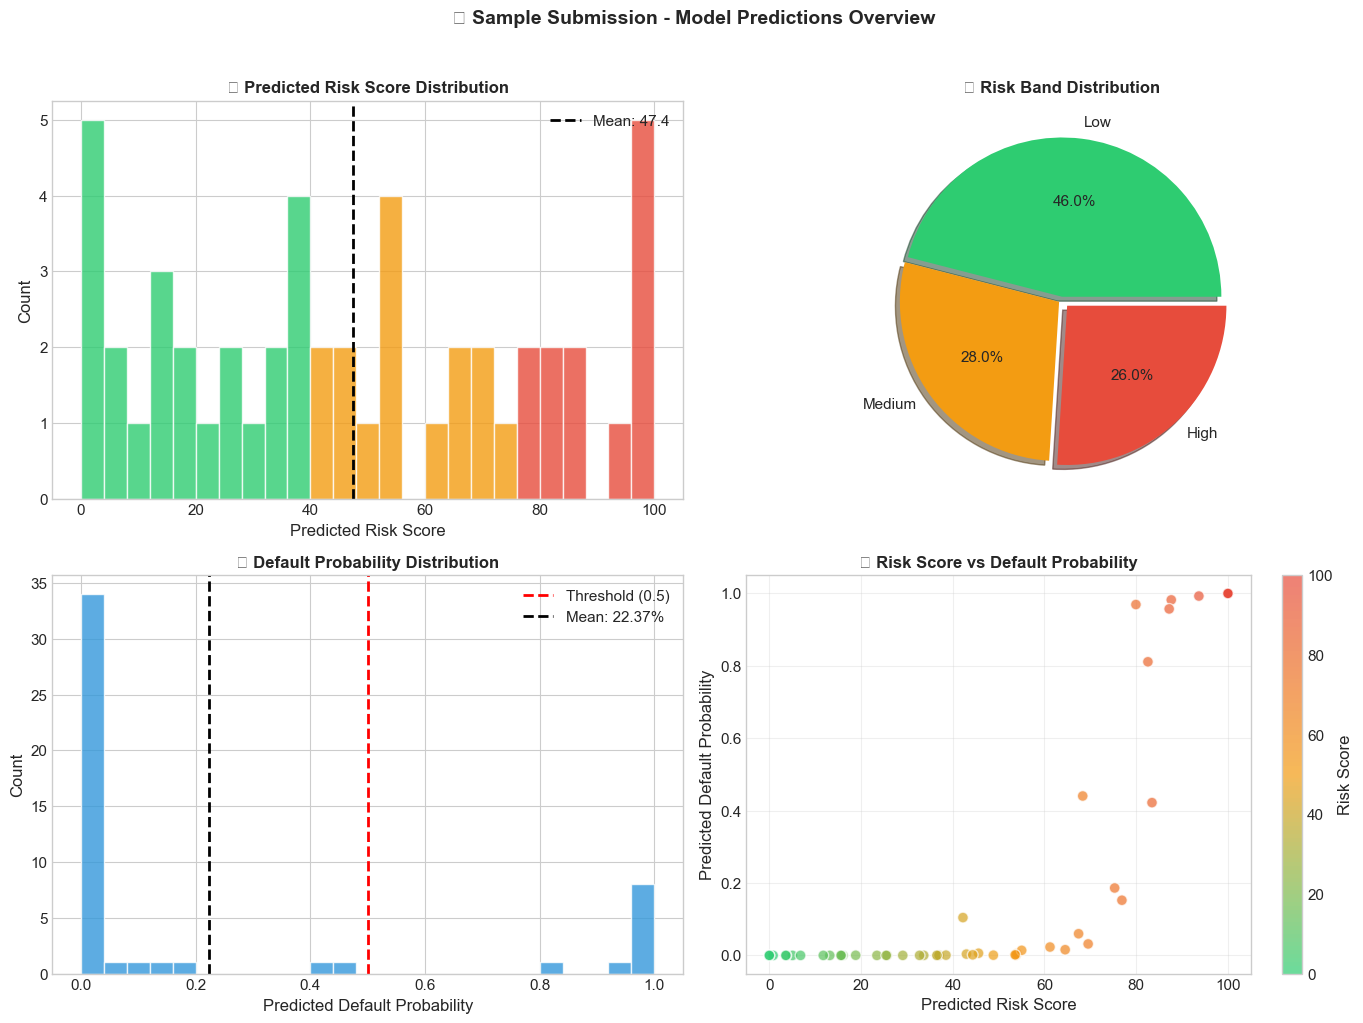


📊 Visualization saved to: ../submissions/prediction_summary.png


In [238]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    VISUALIZE PREDICTIONS
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Risk Score Distribution
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(pred_risk_score, bins=25, edgecolor='white', alpha=0.8)
for i, (patch, left_edge) in enumerate(zip(patches, bins[:-1])):
    if left_edge < 40:
        patch.set_facecolor(RISK_COLORS['low'])
    elif left_edge < 75:
        patch.set_facecolor(RISK_COLORS['medium'])
    else:
        patch.set_facecolor(RISK_COLORS['high'])
ax1.axvline(pred_risk_score.mean(), color='black', linestyle='--', linewidth=2, 
            label=f'Mean: {pred_risk_score.mean():.1f}')
ax1.set_xlabel('Predicted Risk Score')
ax1.set_ylabel('Count')
ax1.set_title('📊 Predicted Risk Score Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Risk Band Pie Chart
ax2 = axes[0, 1]
band_counts = submission_df['predicted_risk_band'].value_counts()
colors_pie = [RISK_COLORS['low'], RISK_COLORS['medium'], RISK_COLORS['high']]
ax2.pie(band_counts.values, labels=band_counts.index, autopct='%1.1f%%',
        colors=colors_pie, explode=(0.02, 0.02, 0.05), shadow=True)
ax2.set_title('🎯 Risk Band Distribution', fontsize=12, fontweight='bold')

# 3. Default Probability Distribution
ax3 = axes[1, 0]
ax3.hist(pred_default_proba, bins=25, color=RISK_COLORS['primary'], 
         edgecolor='white', alpha=0.8)
ax3.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax3.axvline(pred_default_proba.mean(), color='black', linestyle='--', linewidth=2,
            label=f'Mean: {pred_default_proba.mean():.2%}')
ax3.set_xlabel('Predicted Default Probability')
ax3.set_ylabel('Count')
ax3.set_title('📈 Default Probability Distribution', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Risk Score vs Default Probability
ax4 = axes[1, 1]
scatter = ax4.scatter(pred_risk_score, pred_default_proba, 
                       c=pred_risk_score, cmap=risk_cmap, 
                       alpha=0.7, s=60, edgecolor='white')
ax4.set_xlabel('Predicted Risk Score')
ax4.set_ylabel('Predicted Default Probability')
ax4.set_title('🔗 Risk Score vs Default Probability', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Risk Score')

plt.suptitle('📄 Sample Submission - Model Predictions Overview', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../submissions/prediction_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to: ../submissions/prediction_summary.png")